# Evaluate standart benchmarks

Benchmarks Single-Phase Flow

- Poiseuille flow in a tube
- Flow between parallel plates
- Couette flow



In [82]:
## HEADER ## 
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt

In [83]:
# Import py modules to handle .vtu files
sys.path.append('/scratch/local1/krach/data/00_processing/daves_py_modules/')
sys.path.append('/home/david/Arbeit/data/00_processing/daves_py_modules/')
import readwrite
import modify
import vtk_tools

In [84]:
# Global Path
# global_path = ''
global_path = '/scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/'

In [85]:
# define colorbar
cm = plt.cm.get_cmap('RdYlGn_r')

In [94]:
# # Compute figure size
fig_width_pt  = 4*426.79134                       # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27                   # Convert pt to inch
golden_mean   = (np.sqrt(5)-1.0)/2.0        # Aesthetic ratio
fig_width     = fig_width_pt*inches_per_pt  # Width in inches
fig_height    = fig_width*golden_mean       # Height in inches
fig_size      = [fig_width,1.3*fig_height]      # Figure size

plt.rcParams['text.usetex'] = True
plt.rcParams['backend'] = 'pdf'
plt.rcParams['font.size'] = 65
plt.rcParams['legend.fontsize'] = 50
plt.rcParams['xtick.labelsize'] = 50
plt.rcParams['ytick.labelsize'] = 50
plt.rcParams['lines.markersize'] = 40
plt.rcParams['figure.figsize'] = fig_size
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markeredgewidth'] = 6
plt.rcParams['axes.labelsize'] = 60



# plt.rcParams['text.latex.unicode'] = True
plt.rcParams['text.latex.preamble'] = r'''
\usepackage[T1]{fontenc}
\usepackage{amsmath}
%\renewcommand{\familydefault}{\sfdefault}
% more packages here
'''

## Poiseuille Flow
Convergence, discretisation, analytical solution

In [95]:
# Simulation Parameters
fx = 0.1                 # [m/s**2]
lref = 0.001             # [m]
radius = 0.5 * lref      # [m]
rho0 = 1000.0            # [kg/m**3]
viscosity = 0.01         # [Pa s]
dx = [lref/20., lref/30., lref/50, lref/100.]


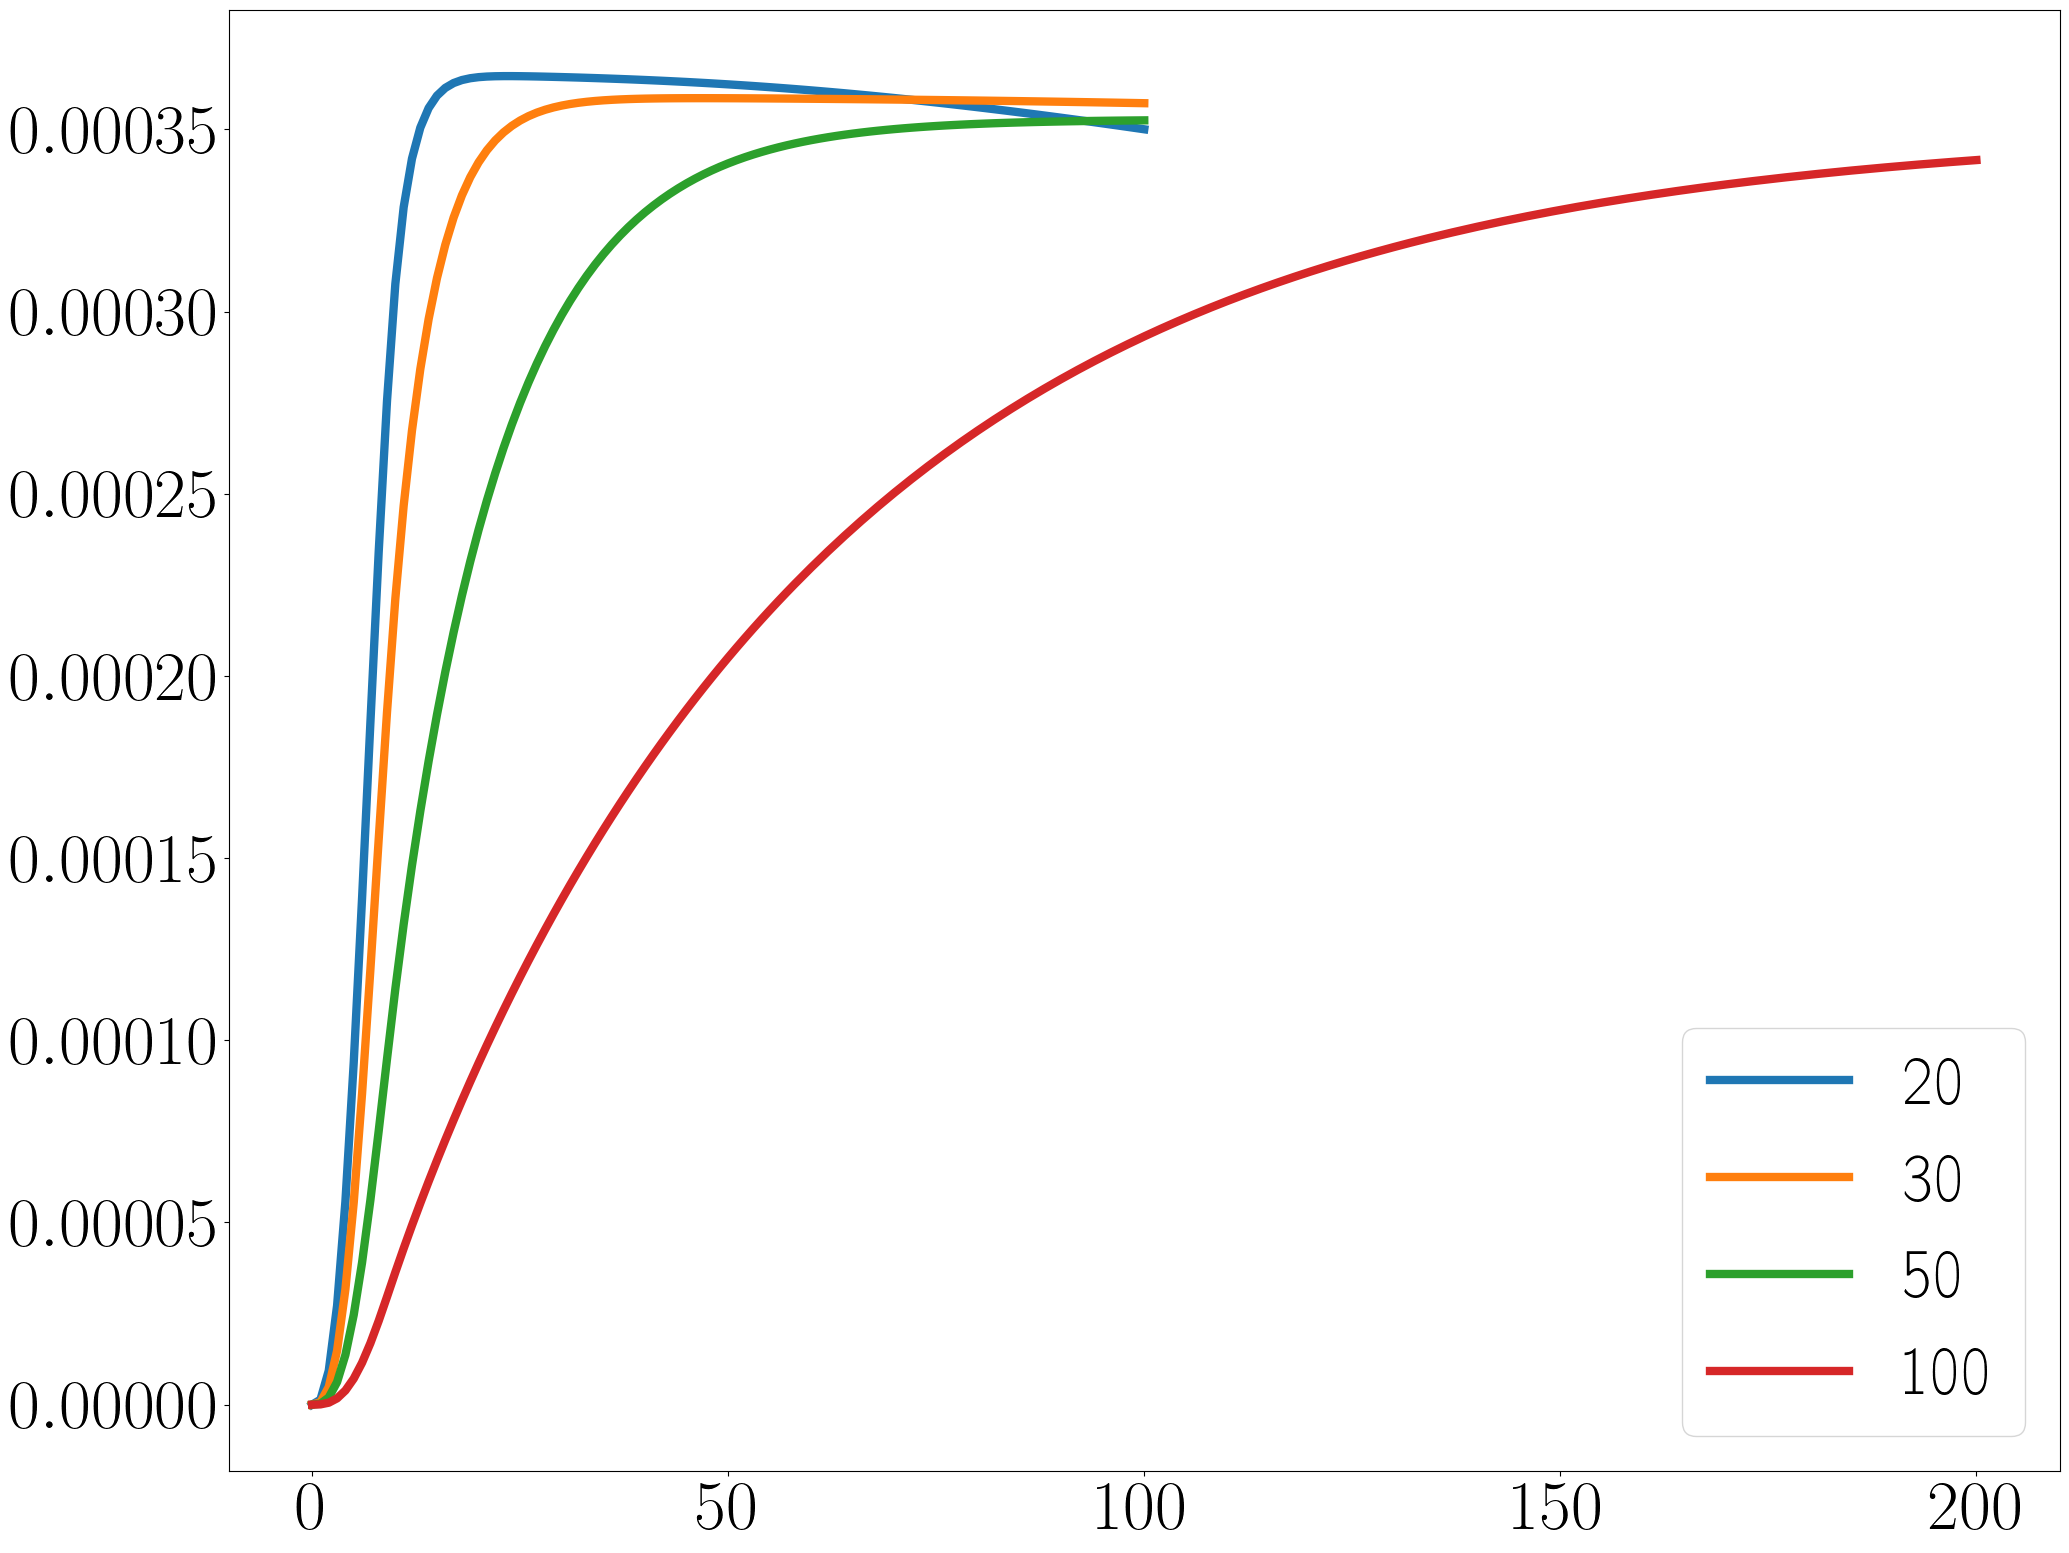

In [96]:
simulations_res = [
                20, 
                30, 
                50, 
                100
]

path_poiseuille = '01_poiseuille'
logfiles_poiseuille = [
    'poiseuille_flow_20_32_32_vs_5e-05_run.log',
    'poiseuille_flow_30_42_42_vs_3.3333333333333335e-05_run.log',
    'poiseuille_flow_50_62_62_vs_2e-05_run.log',
    'poiseuille_flow_100_112_112_vs_1e-05_run.log'
]

for i in range(len(simulations_res)):
    conv_data = np.genfromtxt(f'{global_path}{path_poiseuille}/{logfiles_poiseuille[i]}', skip_header = 1)[:, -2]
    number_fparticles = np.genfromtxt(f'{global_path}{path_poiseuille}/{logfiles_poiseuille[i]}', skip_header = 1)[-1, -3]
    norm_conv_data = np.divide(conv_data, number_fparticles)
    plt.plot(norm_conv_data, label = f'{simulations_res[i]}')
    plt.legend()
plt.show()

In [97]:
# analytical solution
xaxis = np.linspace(-radius, radius, num = 100)
a = []

for i in range(xaxis.shape[0]):
    a.append( (fx * rho0)/(4.0*viscosity) * (((radius+dx[0])**2) - xaxis[i]**2))

a  = np.asarray(a)

In [108]:
# Comparison with a analytical solution
vtufiles =  [
    'poiseuille_flow_20_32_32_vs_5e-05_run/poiseuille_flow_20_32_32_vs_5e-05_run_10000.vtu',
    'poiseuille_flow_30_42_42_vs_3.3333333333333335e-05_run/poiseuille_flow_30_42_42_vs_3.3333333333333335e-05_run_10000.vtu',
    'poiseuille_flow_50_62_62_vs_2e-05_run/poiseuille_flow_50_62_62_vs_2e-05_run_10000.vtu',
    'poiseuille_flow_100_112_112_vs_1e-05_run/poiseuille_flow_100_112_112_vs_1e-05_run_20000.vtu'
]
counter = 0
for i in range(len(vtufiles)):
    
    # analytical solution
    xaxis = np.linspace(-radius-dx[i]/2, radius+dx[i]/2, num = 100)
    a = []

    for j in range(xaxis.shape[0]):
        a.append( (fx * rho0)/(4.0*viscosity) * (((radius+(dx[i]/2))**2) - xaxis[j]**2))

    a  = np.asarray(a)
    
    data = vtk_tools.openvtu(f'{global_path}{path_poiseuille}/{vtufiles[i]}', ['Pressure', 'Velocity x', 'Velocity y'])

    # print(data20['Points'])
    tdata_points_y = []
    tdata_points_z = []
    tdata_vels = []
    for k in range(data['Points'].shape[0]):
        if data['Points'][k, 0] < 0.0001  and data['Points'][k, 0] > -0.0001:
            tdata_points_y.append(data['Points'][k, 1])
            tdata_points_z.append(data['Points'][k, 2])
            tdata_vels.append(data['Velocity x'][k])

    im = plt.scatter(tdata_points_y, tdata_points_z, c = tdata_vels, s = 80, cmap = cm)
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel(r'$\mathrm{particle}\, \mathrm{velocity} \, \mathbf{v}_i \quad [\mathrm{m}/\mathrm{s}]$')
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'all_poi_{counter}.pdf')
    plt.savefig(f'all_poi_{counter}.png')
    plt.close()
    # Flow Profiles

    tt_points_profile_y = []
    tt_points_profile_z = []
    tt_vels_profile_y = []
    tt_vels_profile_z = []

    for l in range(len(tdata_points_y)):
        if tdata_points_y[l] < 0.00005 and tdata_points_y[l] > -0.000005:
            tt_points_profile_z.append(tdata_points_z[l])
            tt_vels_profile_z.append(tdata_vels[l])

    plt.scatter(tt_points_profile_z, tt_vels_profile_z, c = tt_vels_profile_z, s = 40, cmap = cm)
    plt.plot(xaxis, a)
    #plt.show()
    plt.tight_layout()
    plt.savefig(f'profile_poi_{counter}.pdf')
    plt.savefig(f'profile_poi_{counter}.png')
    plt.close()
    counter += 1



read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/01_poiseuille/poiseuille_flow_20_32_32_vs_5e-05_run/poiseuille_flow_20_32_32_vs_5e-05_run_10000.vtu
read_vtk.py: Read Positions: Number of loaded points 20480
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y
read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/01_poiseuille/poiseuille_flow_30_42_42_vs_3.3333333333333335e-05_run/poiseuille_flow_30_42_42_vs_3.3333333333333335e-05_run_10000.vtu
read_vtk.py: Read Positions: Number of loaded points 52920
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y
read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/01_poiseuille/poiseuille_flow_50_62_6

## Parallel Plates 
Convergence, discretisation and analytical solution


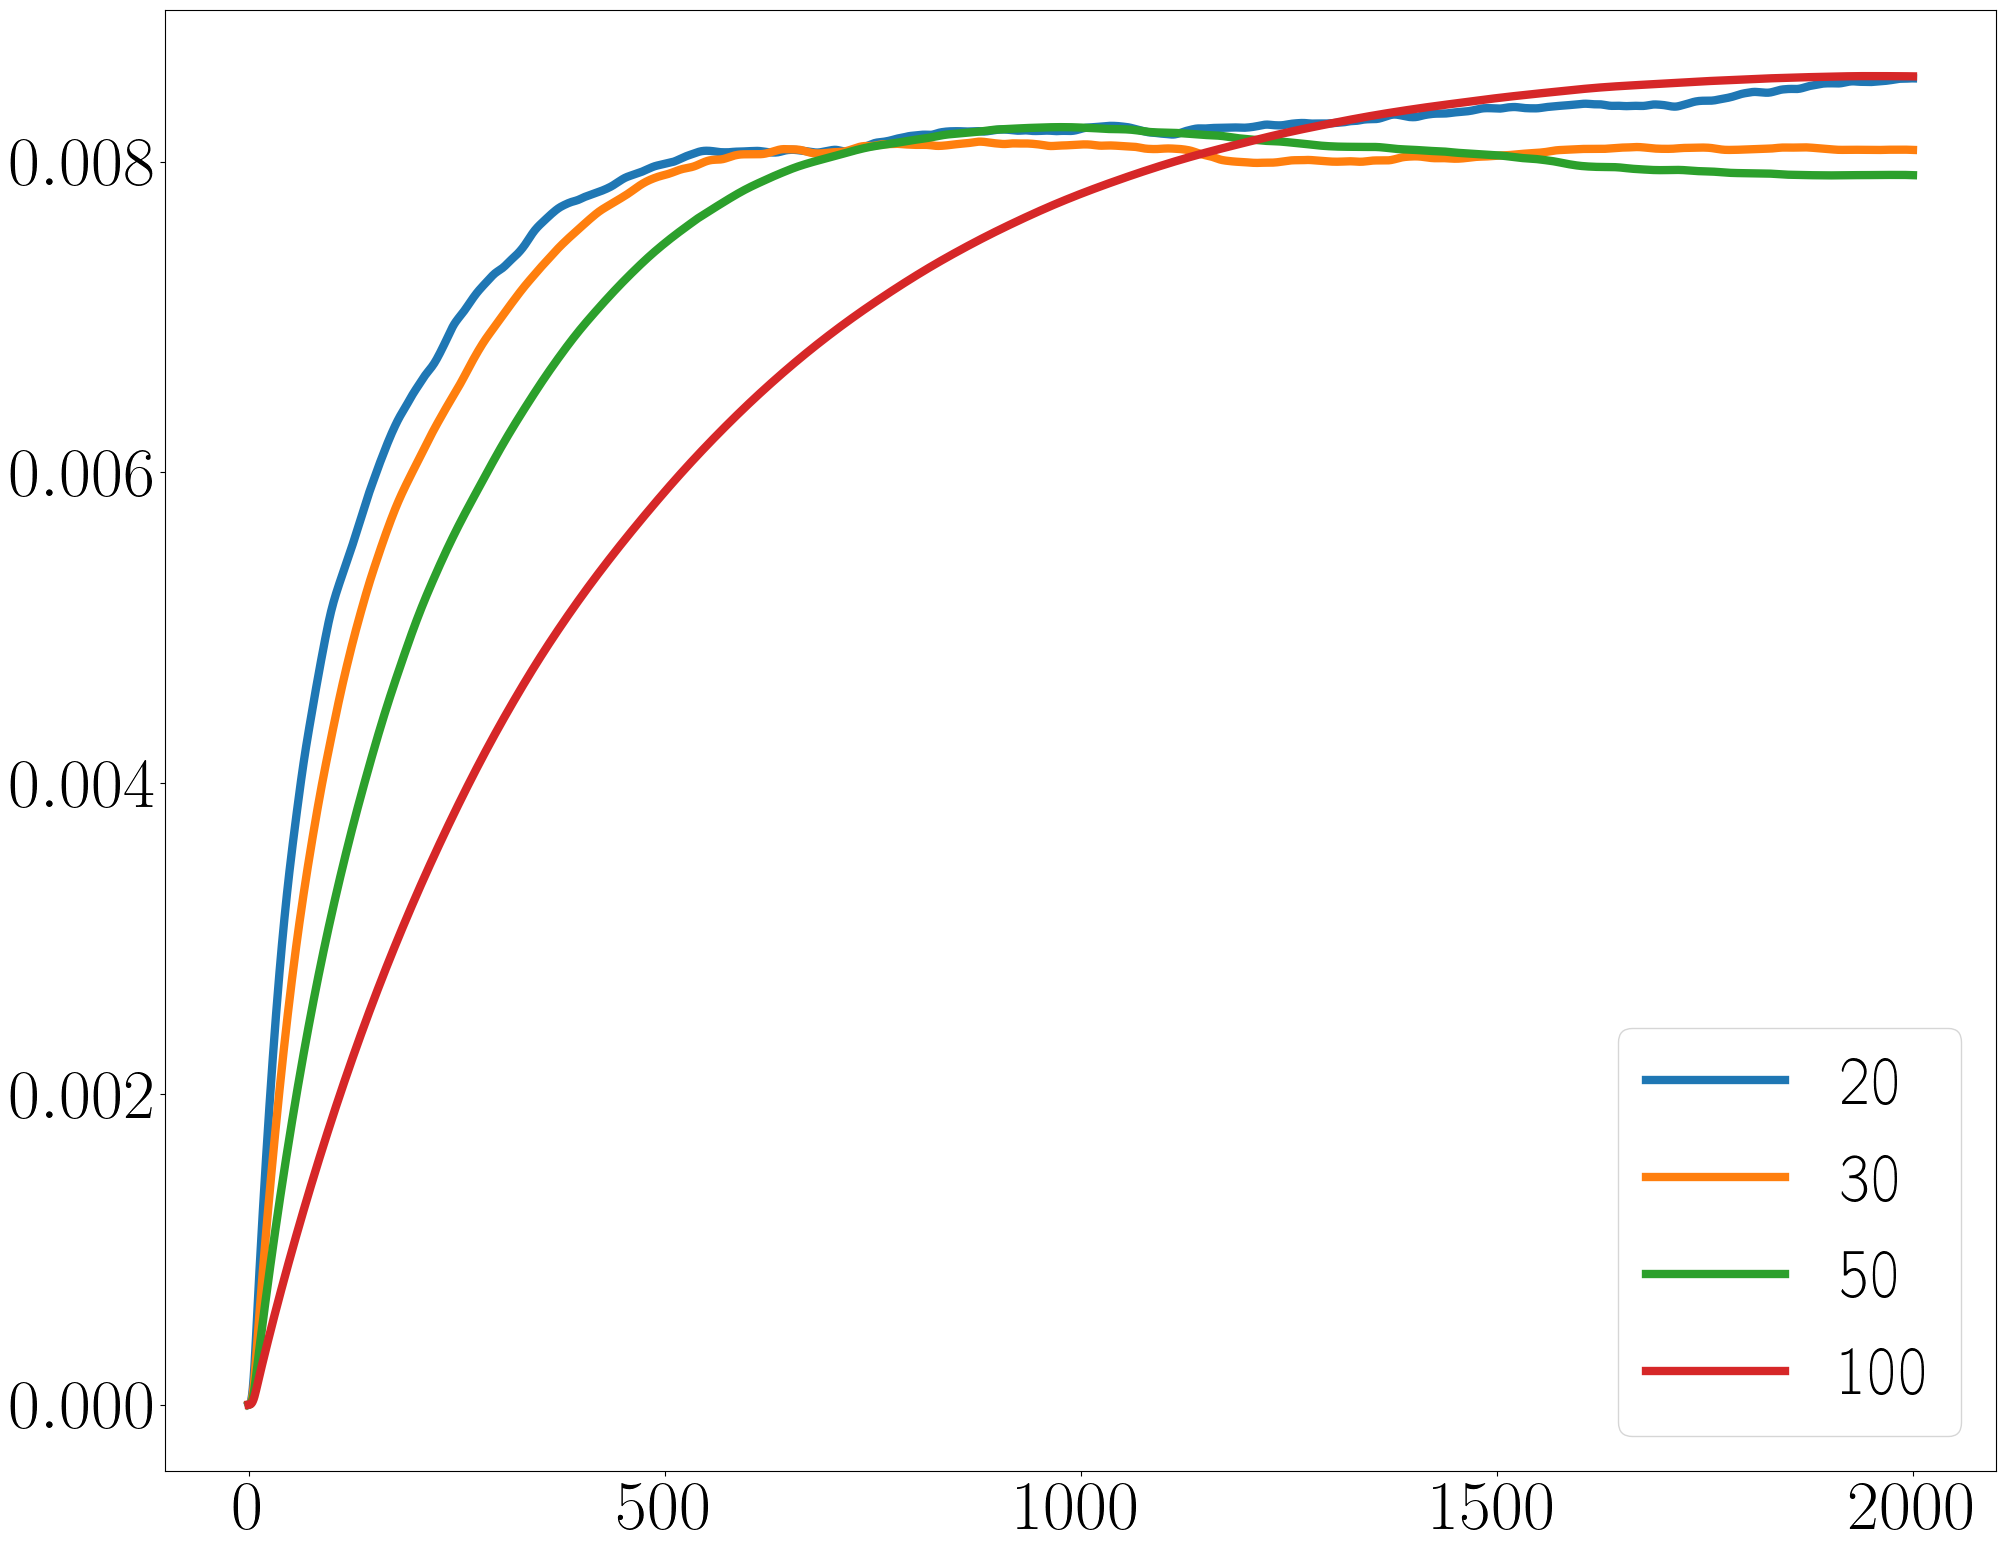

In [99]:
simulations_res = [
                    20, 
                    30, 
                    50, 
                    100
]

path_plates = '02_parallel_plates'
logfiles_plates = [
    'parallel_plates_20_32_17_vs_5e-05_run.log',
    'parallel_plates_30_42_17_vs_3.3333333333333335e-05_run.log',
    'parallel_plates_50_62_17_vs_2e-05_run.log',
    'parallel_plates_100_112_17_vs_1e-05_run.log'
]

for i in range(len(simulations_res)):
    conv_data = np.genfromtxt(f'{global_path}{path_plates}/{logfiles_plates[i]}', skip_header = 1)[:, -2]
    number_fparticles = np.genfromtxt(f'{global_path}{path_plates}/{logfiles_plates[i]}', skip_header = 1)[-1, -3]
    norm_conv_data = np.divide(conv_data, number_fparticles)
    plt.plot(norm_conv_data, label = f'{simulations_res[i]}')
    plt.legend()
plt.show()

In [100]:
# Simulation Parameters
fx = 0.1                 # [m/s**2]
lref = 0.001             # [m]
radius = 0.5 * lref      # [m]
rho0 = 1000.0            # [kg/m**3]
viscosity = 0.001         # [Pa s]
dx = [lref/20., lref/30., lref/50, lref/100.]

In [101]:
# Comparison with a analytical solution
vtufiles =  [
    'parallel_plates_20_32_17_vs_5e-05_run/parallel_plates_20_32_17_vs_5e-05_run_200000.vtu',
    'parallel_plates_30_42_17_vs_3.3333333333333335e-05_run/parallel_plates_30_42_17_vs_3.3333333333333335e-05_run_200000.vtu',
    'parallel_plates_50_62_17_vs_2e-05_run/parallel_plates_50_62_17_vs_2e-05_run_200000.vtu',
    'parallel_plates_100_112_17_vs_1e-05_run/parallel_plates_100_112_17_vs_1e-05_run_200000.vtu'
]

counter = 0

for i in range(len(vtufiles)):
    
    xaxis = np.linspace(-radius-dx[i]/2, radius+dx[i]/2, num = 100)
    a = []

    for j in range(xaxis.shape[0]):
        a.append( (fx * rho0)/(2.0*viscosity) * (((radius+(dx[i]/2))**2) - xaxis[j]**2))

    a  = np.asarray(a)
    
    data = vtk_tools.openvtu(f'{global_path}{path_plates}/{vtufiles[i]}', ['Pressure', 'Velocity x', 'Velocity y'])

    # print(data20['Points'])
    tdata_points_y = []
    tdata_points_z = []
    tdata_vels = []
    for k in range(data['Points'].shape[0]):
        if data['Points'][k, 0] < 0.0003  and data['Points'][k, 0] > -0.0003:
            tdata_points_y.append(data['Points'][k, 2])
            tdata_points_z.append(data['Points'][k, 1])
            tdata_vels.append(data['Velocity x'][k])

    im = plt.scatter(tdata_points_z, tdata_points_y, c = tdata_vels, s = 40, cmap = cm)
    plt.colorbar(im)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'all_{counter}.pdf')
    plt.savefig(f'all_{counter}.png')
    plt.close()
    # Flow Profiles

    tt_points_profile_y = []
    tt_points_profile_z = []
    tt_vels_profile_y = []
    tt_vels_profile_z = []

    for l in range(len(tdata_points_y)):
        if tdata_points_y[l] < 0.00005 and tdata_points_y[l] > -0.000005:
            tt_points_profile_z.append(tdata_points_z[l])
            tt_vels_profile_z.append(tdata_vels[l])

    plt.scatter(tt_points_profile_z, tt_vels_profile_z, c = tt_vels_profile_z, s = 40, cmap = cm)
    plt.plot(xaxis, a)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'profil_{counter}.pdf')
    plt.savefig(f'profil_{counter}.png')
    plt.close()
    
    counter += 1

read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/02_parallel_plates/parallel_plates_20_32_17_vs_5e-05_run/parallel_plates_20_32_17_vs_5e-05_run_200000.vtu
read_vtk.py: Read Positions: Number of loaded points 10880
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y
read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/02_parallel_plates/parallel_plates_30_42_17_vs_3.3333333333333335e-05_run/parallel_plates_30_42_17_vs_3.3333333333333335e-05_run_200000.vtu
read_vtk.py: Read Positions: Number of loaded points 21420
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y
read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/02_parallel_plates/parall

## Couette Flow
Convergence, discretisation, and analytical solution

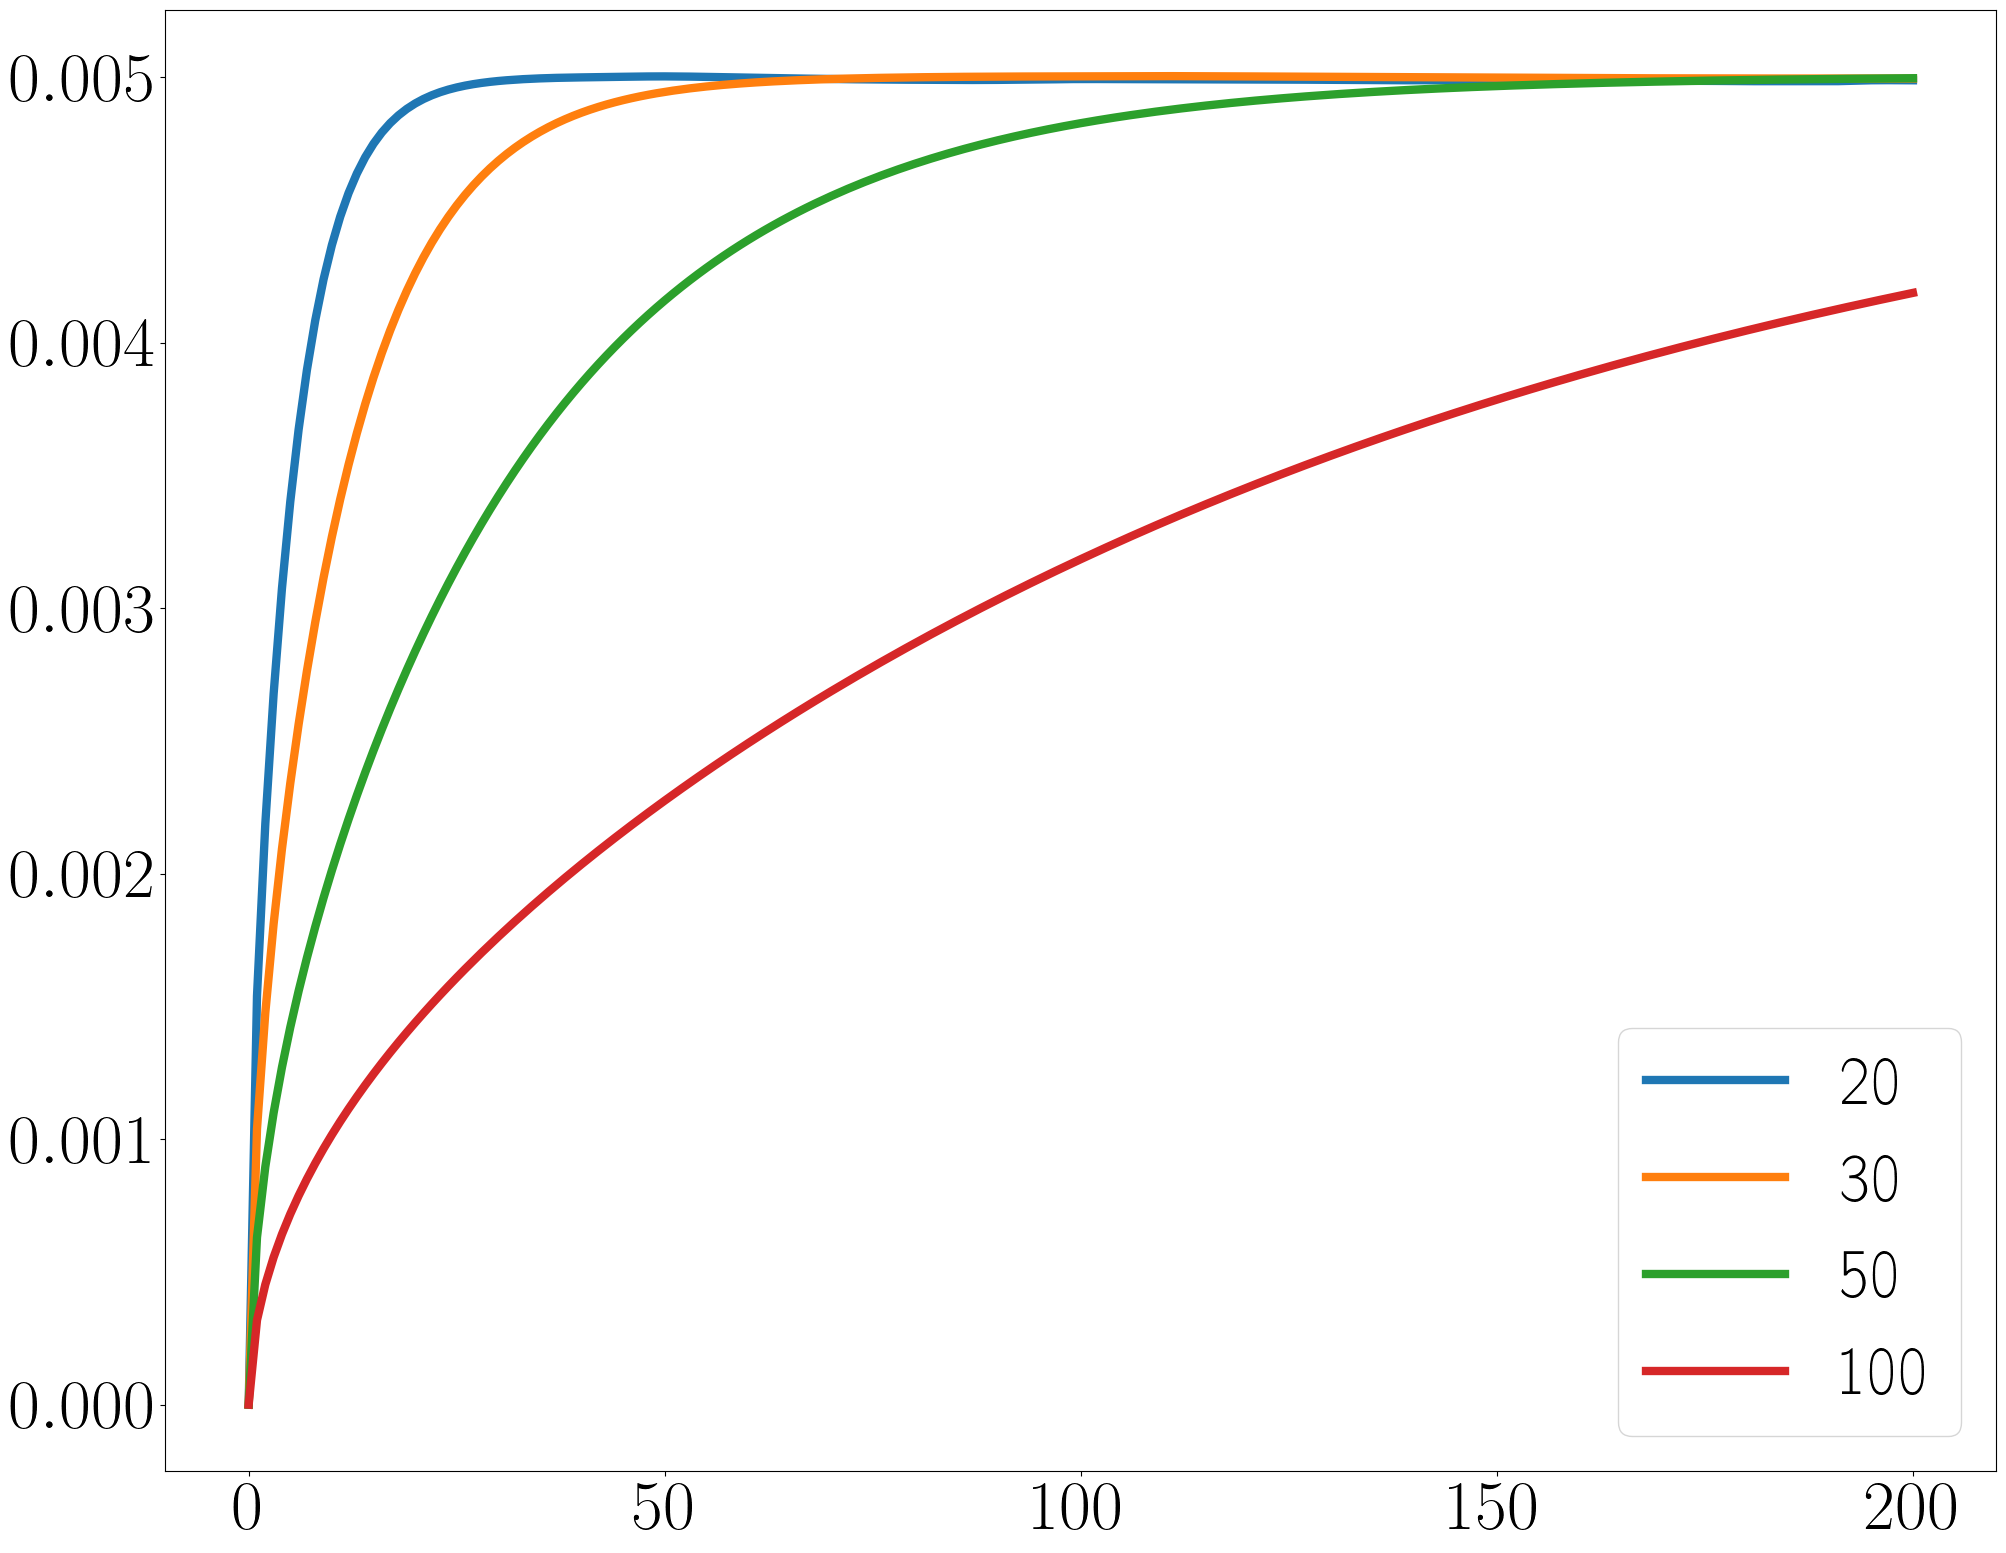

In [102]:
simulations_res = [
                    20, 
                    30, 
                    50, 
                    100
]

path_couette = '03_couette_flow'
logfiles_couette = [
    'couette_flow_20_28_17_vs_5e-05_run.log',
    'couette_flow_30_38_17_vs_3.3333333333333335e-05_run.log',
    'couette_flow_50_58_17_vs_2e-05_run.log',
    'couette_flow_100_108_17_vs_1e-05_run.log'
]

for i in range(len(simulations_res)):
    conv_data = np.genfromtxt(f'{global_path}{path_couette}/{logfiles_couette[i]}', skip_header = 1)[:, -2]
    number_fparticles = np.genfromtxt(f'{global_path}{path_couette}/{logfiles_couette[i]}', skip_header = 1)[-1, -3]
    norm_conv_data = np.divide(conv_data, number_fparticles)
    plt.plot(norm_conv_data, label = f'{simulations_res[i]}')
    plt.legend()
plt.show()

read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/03_couette_flow/couette_flow_20_28_17_vs_5e-05_run/couette_flow_20_28_17_vs_5e-05_run_20000.vtu
read_vtk.py: Read Positions: Number of loaded points 9520
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y


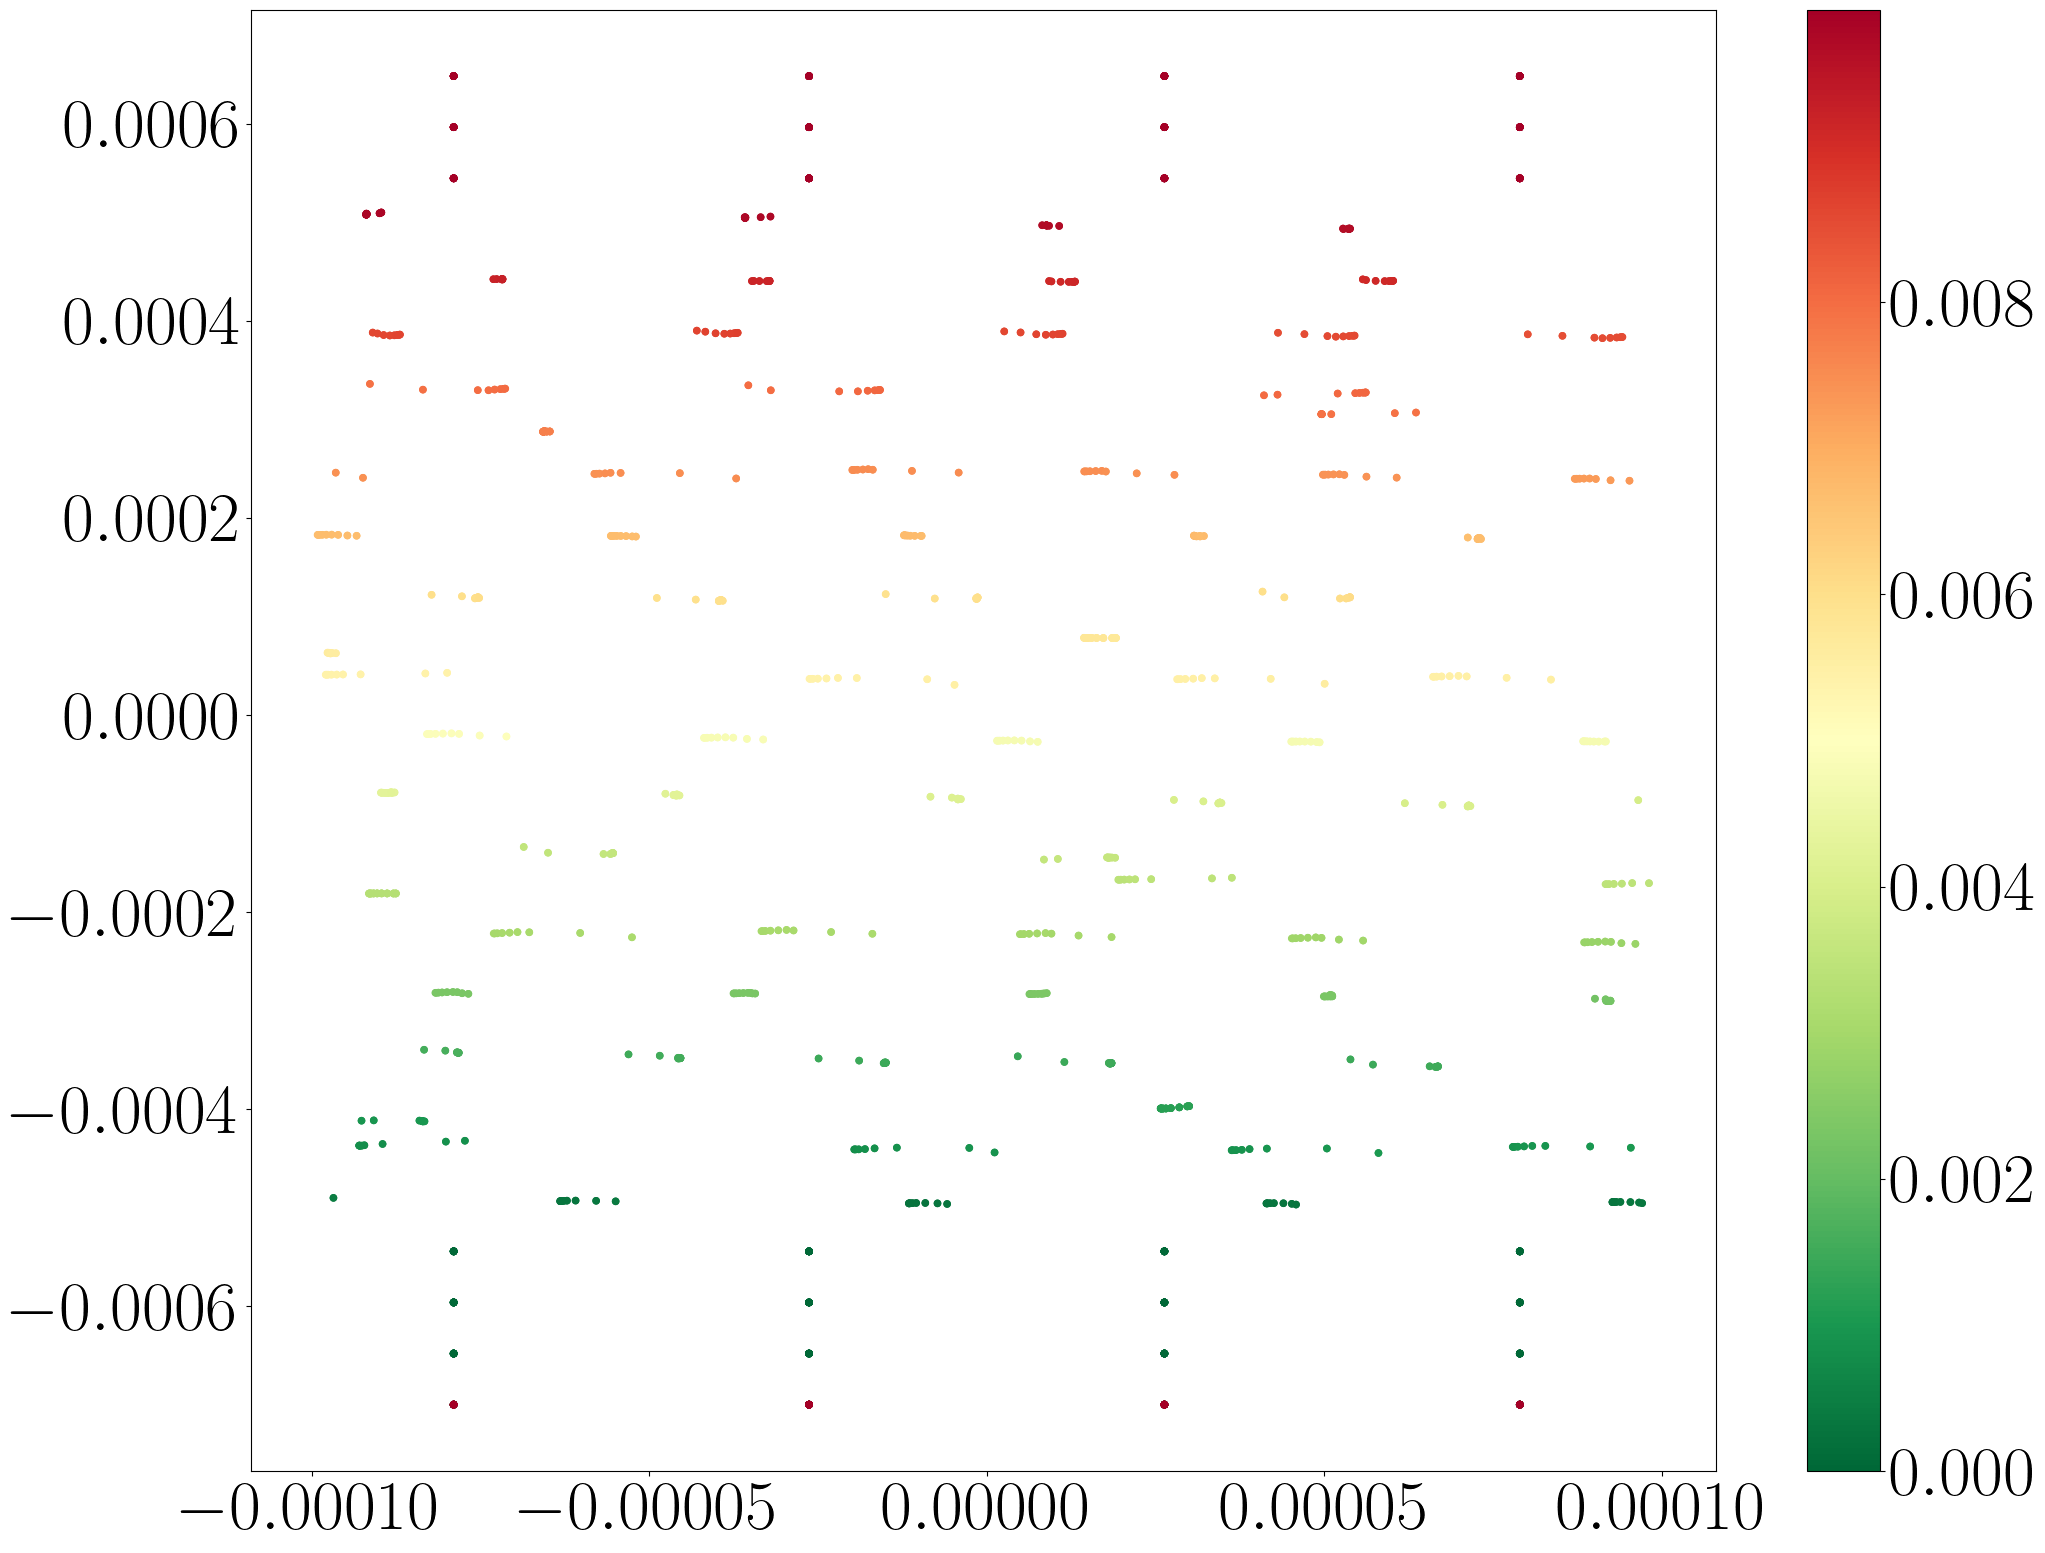

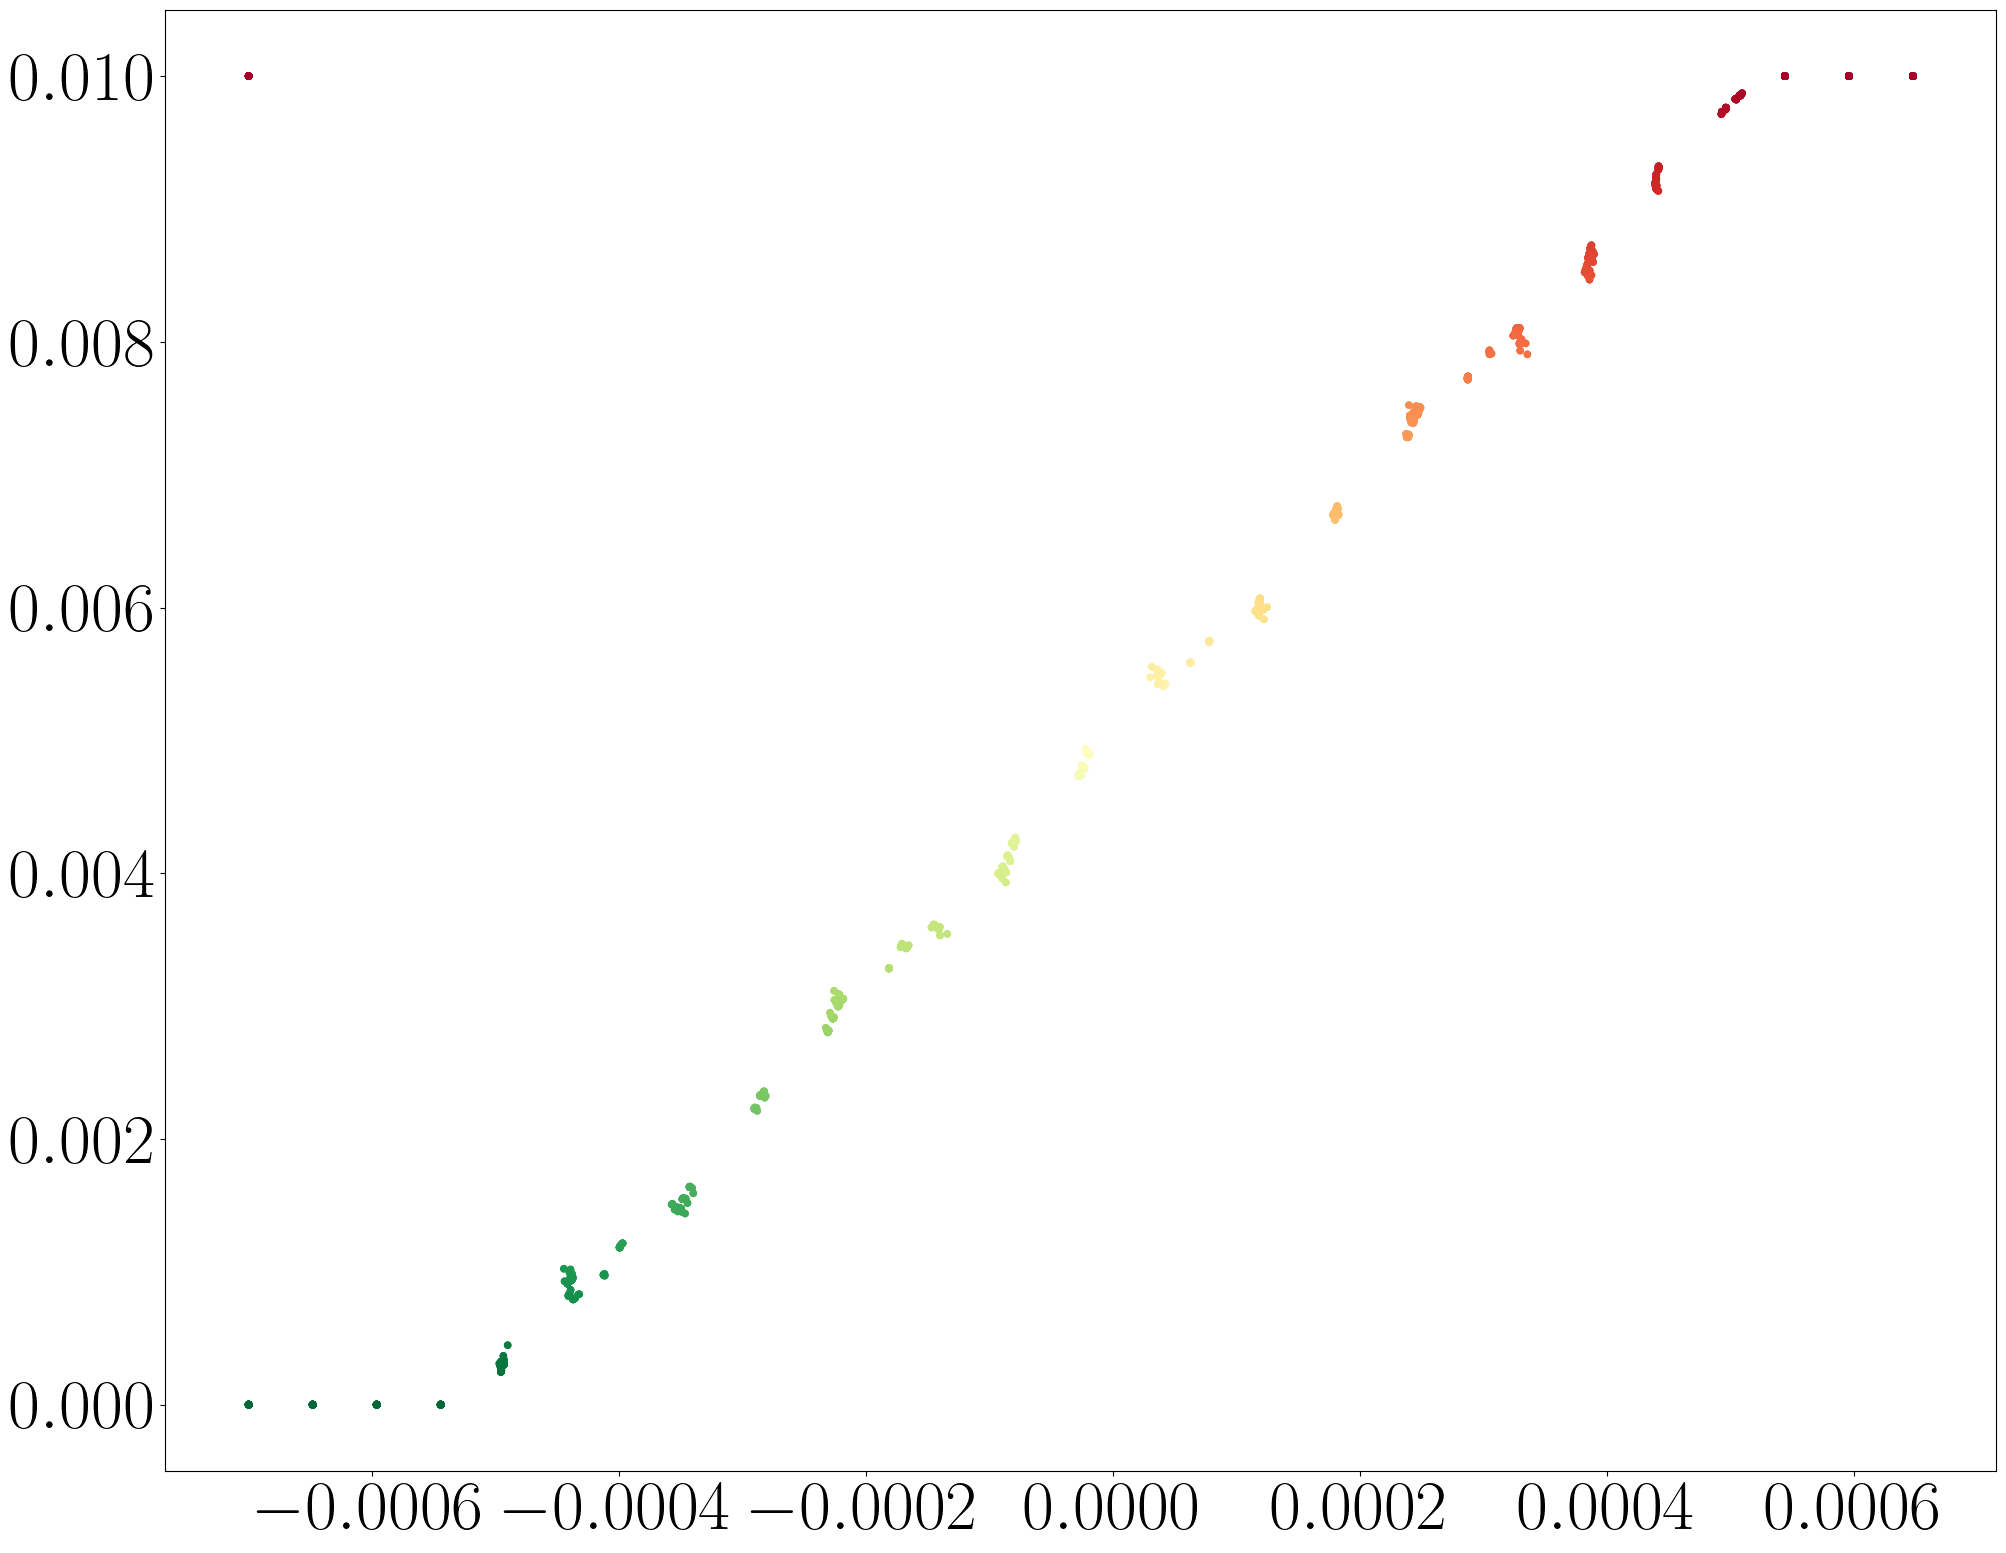

read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/03_couette_flow/couette_flow_30_38_17_vs_3.3333333333333335e-05_run/couette_flow_30_38_17_vs_3.3333333333333335e-05_run_20000.vtu
read_vtk.py: Read Positions: Number of loaded points 19380
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y


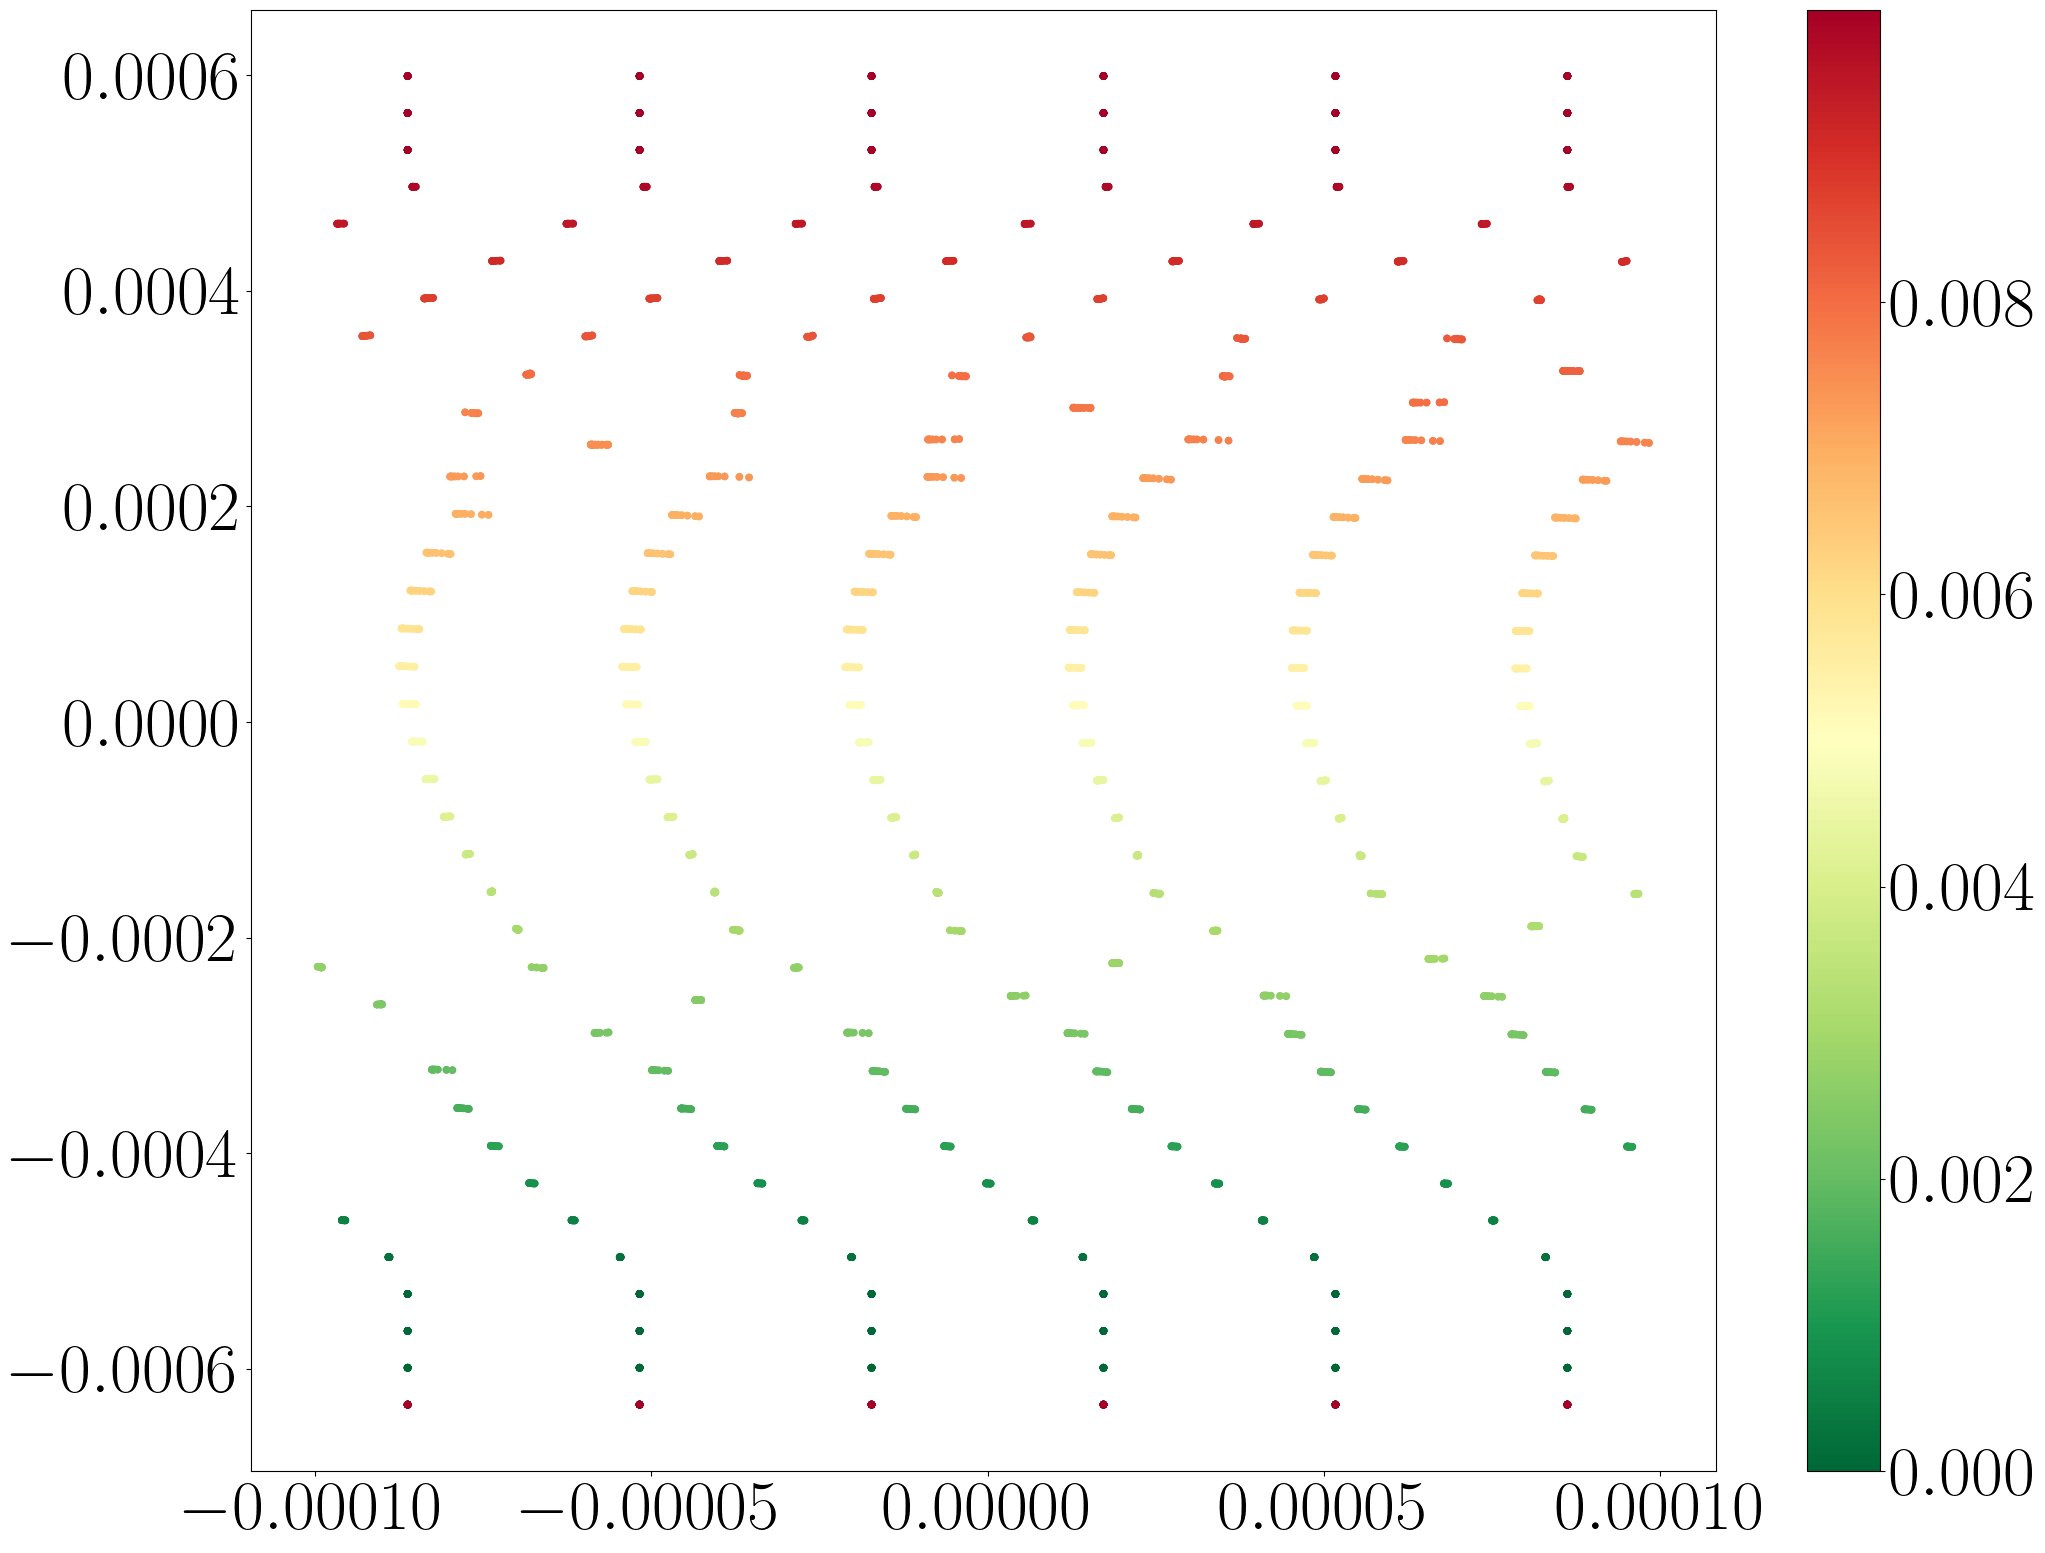

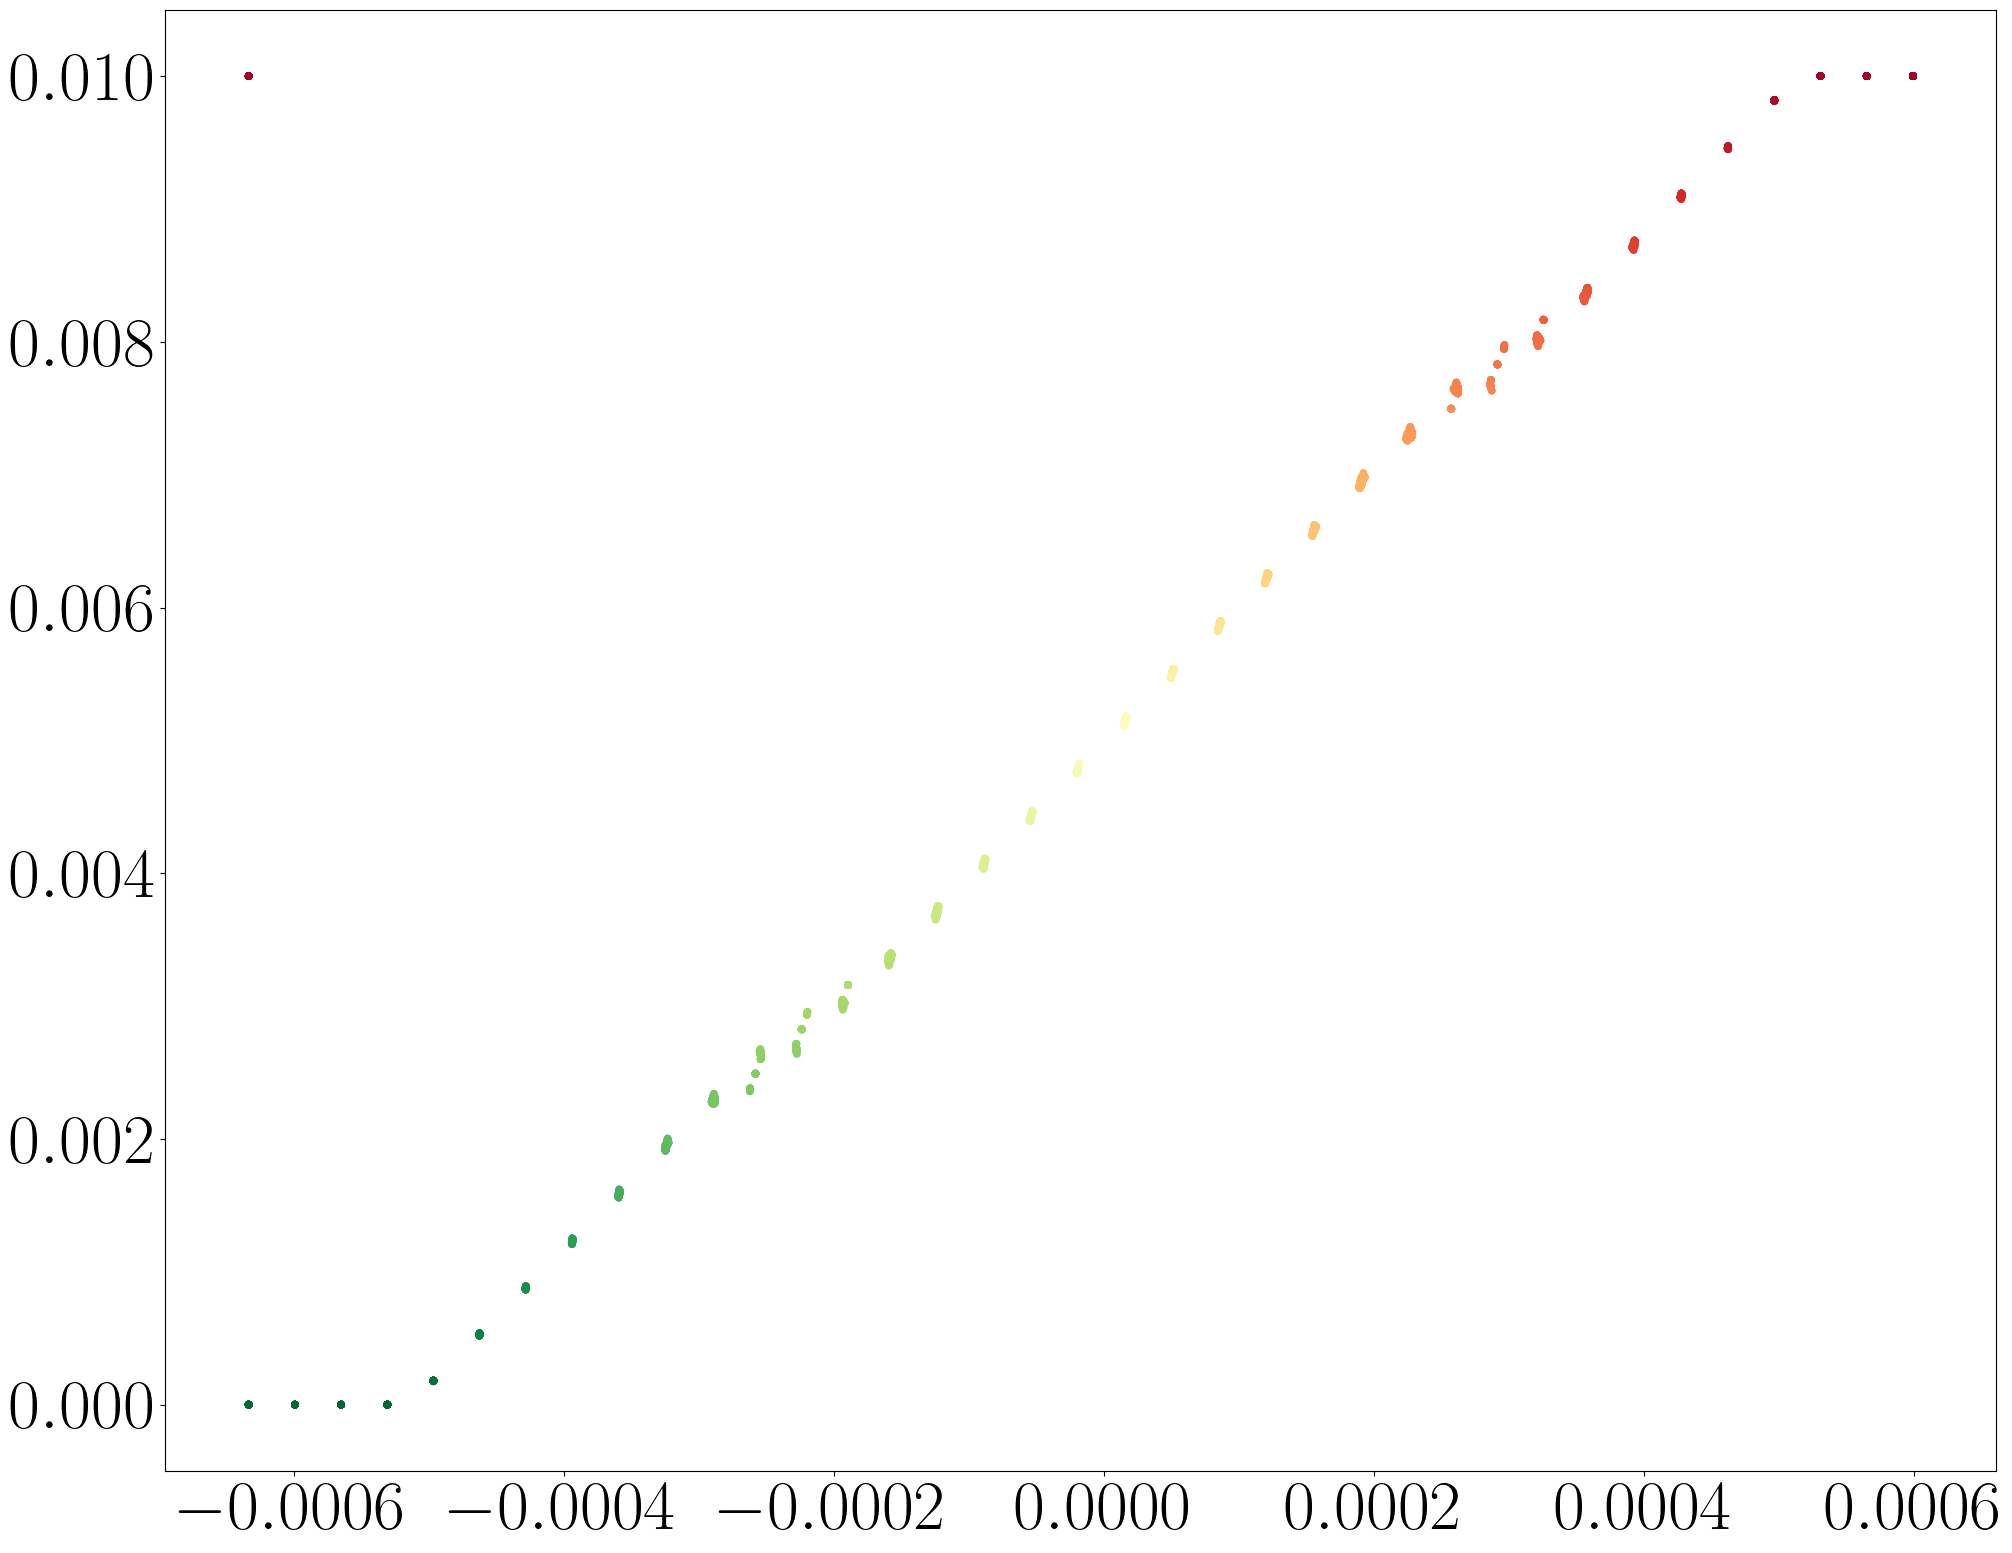

read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/03_couette_flow/couette_flow_50_58_17_vs_2e-05_run/couette_flow_50_58_17_vs_2e-05_run_20000.vtu
read_vtk.py: Read Positions: Number of loaded points 49300
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y


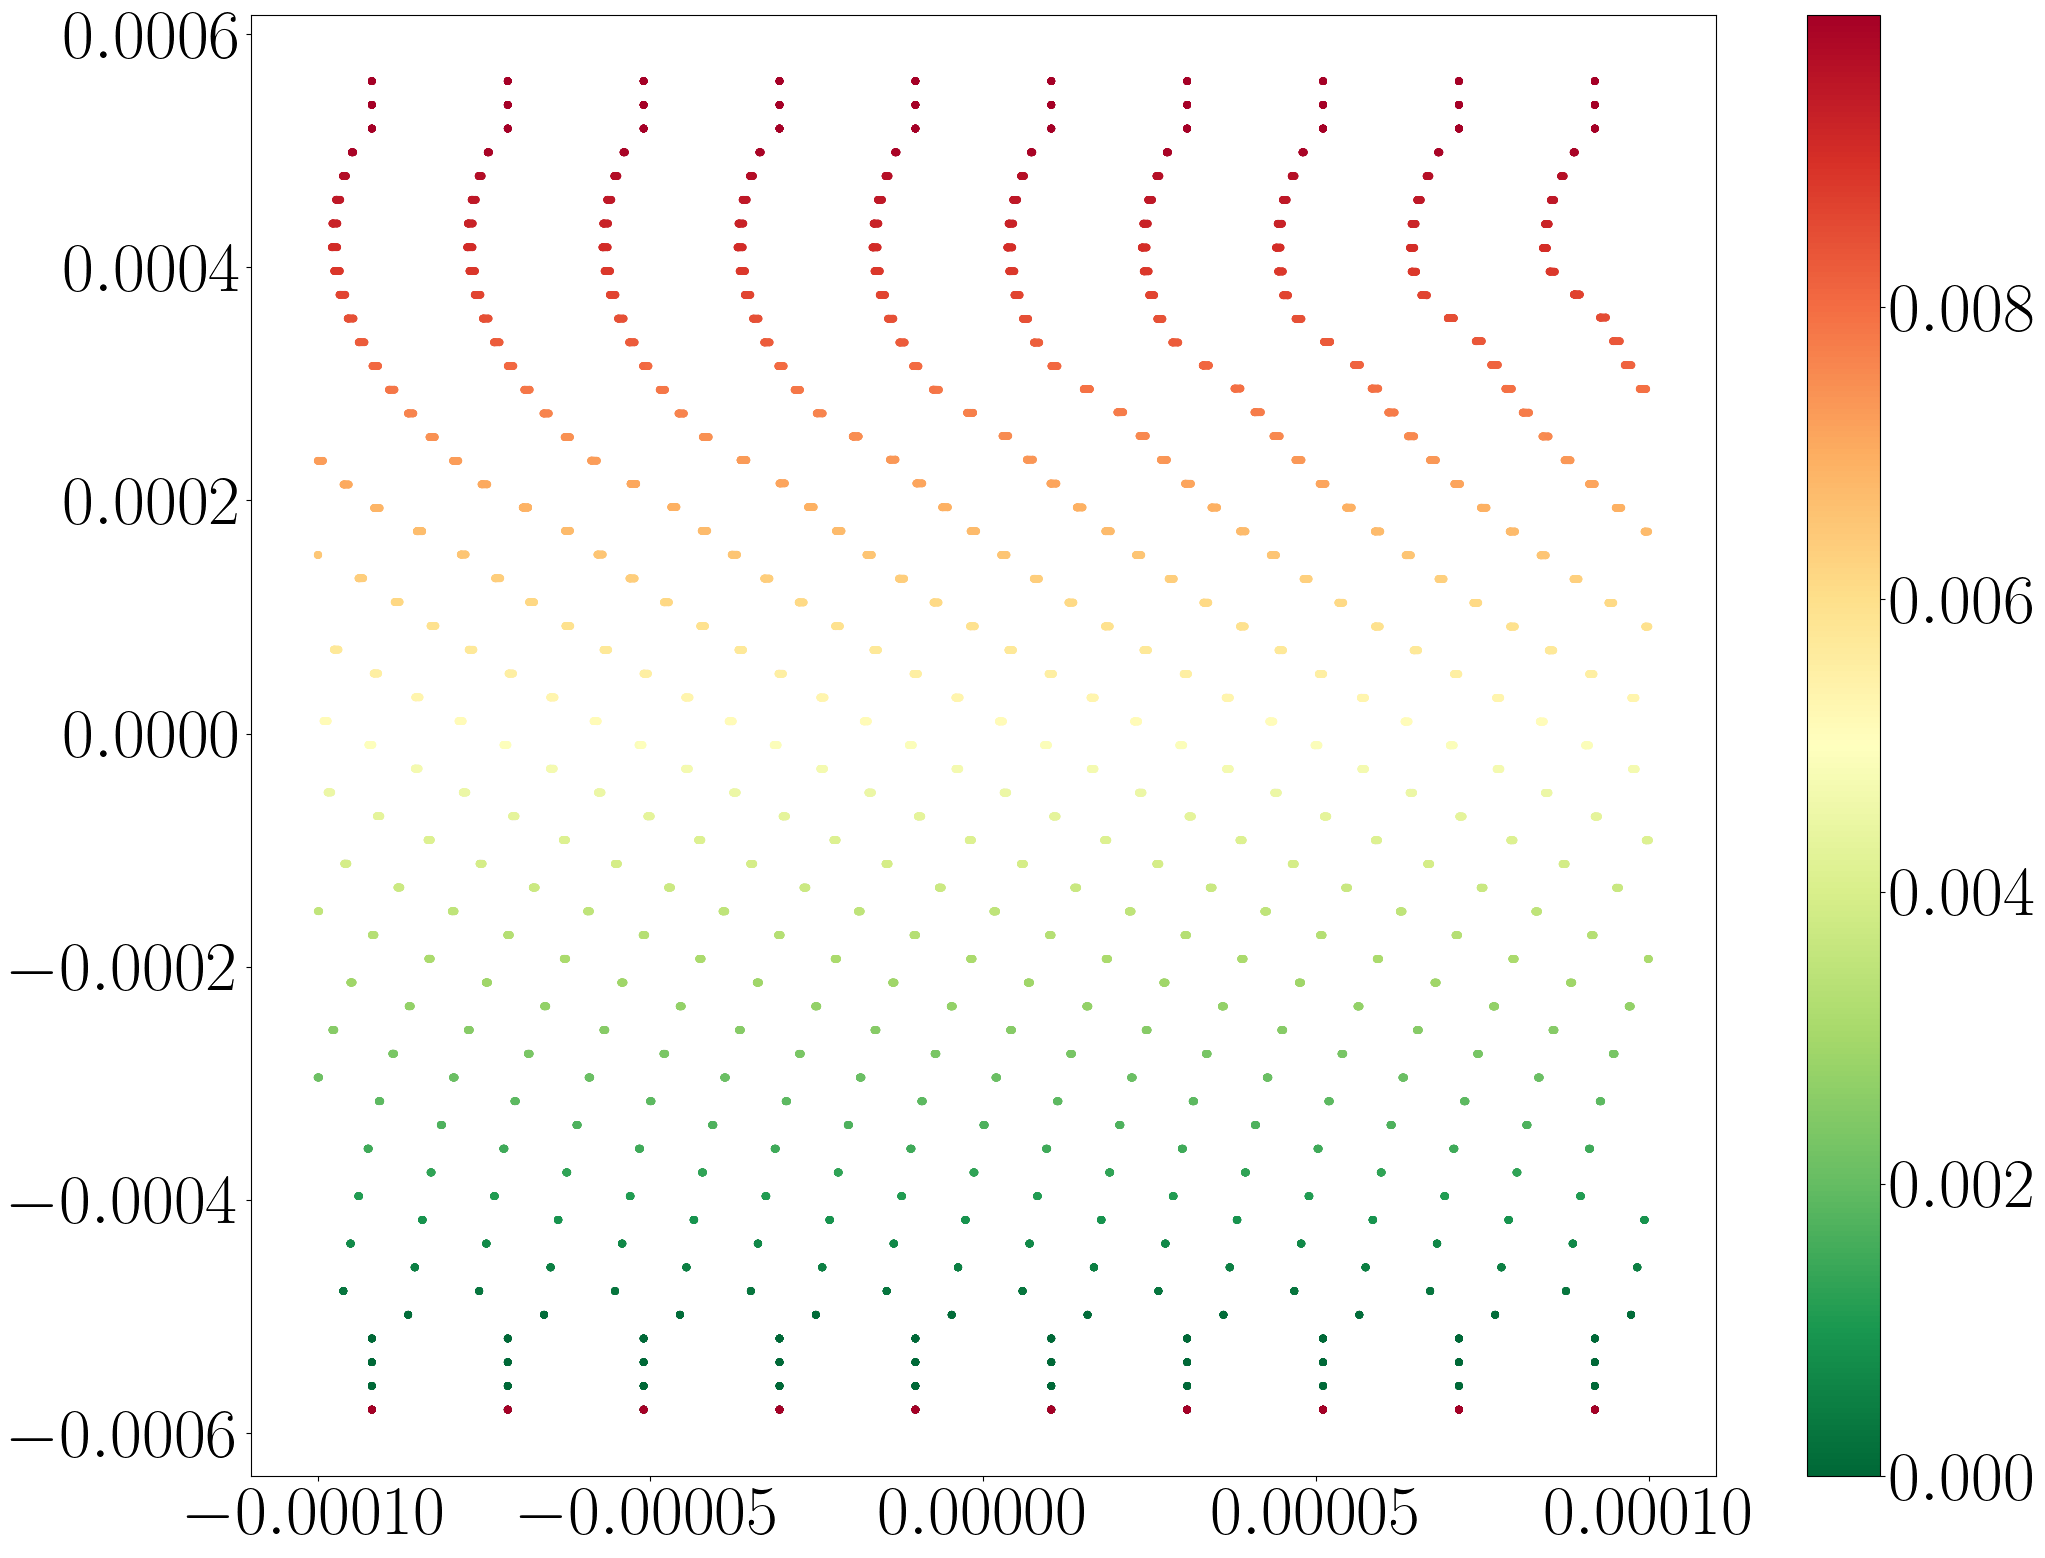

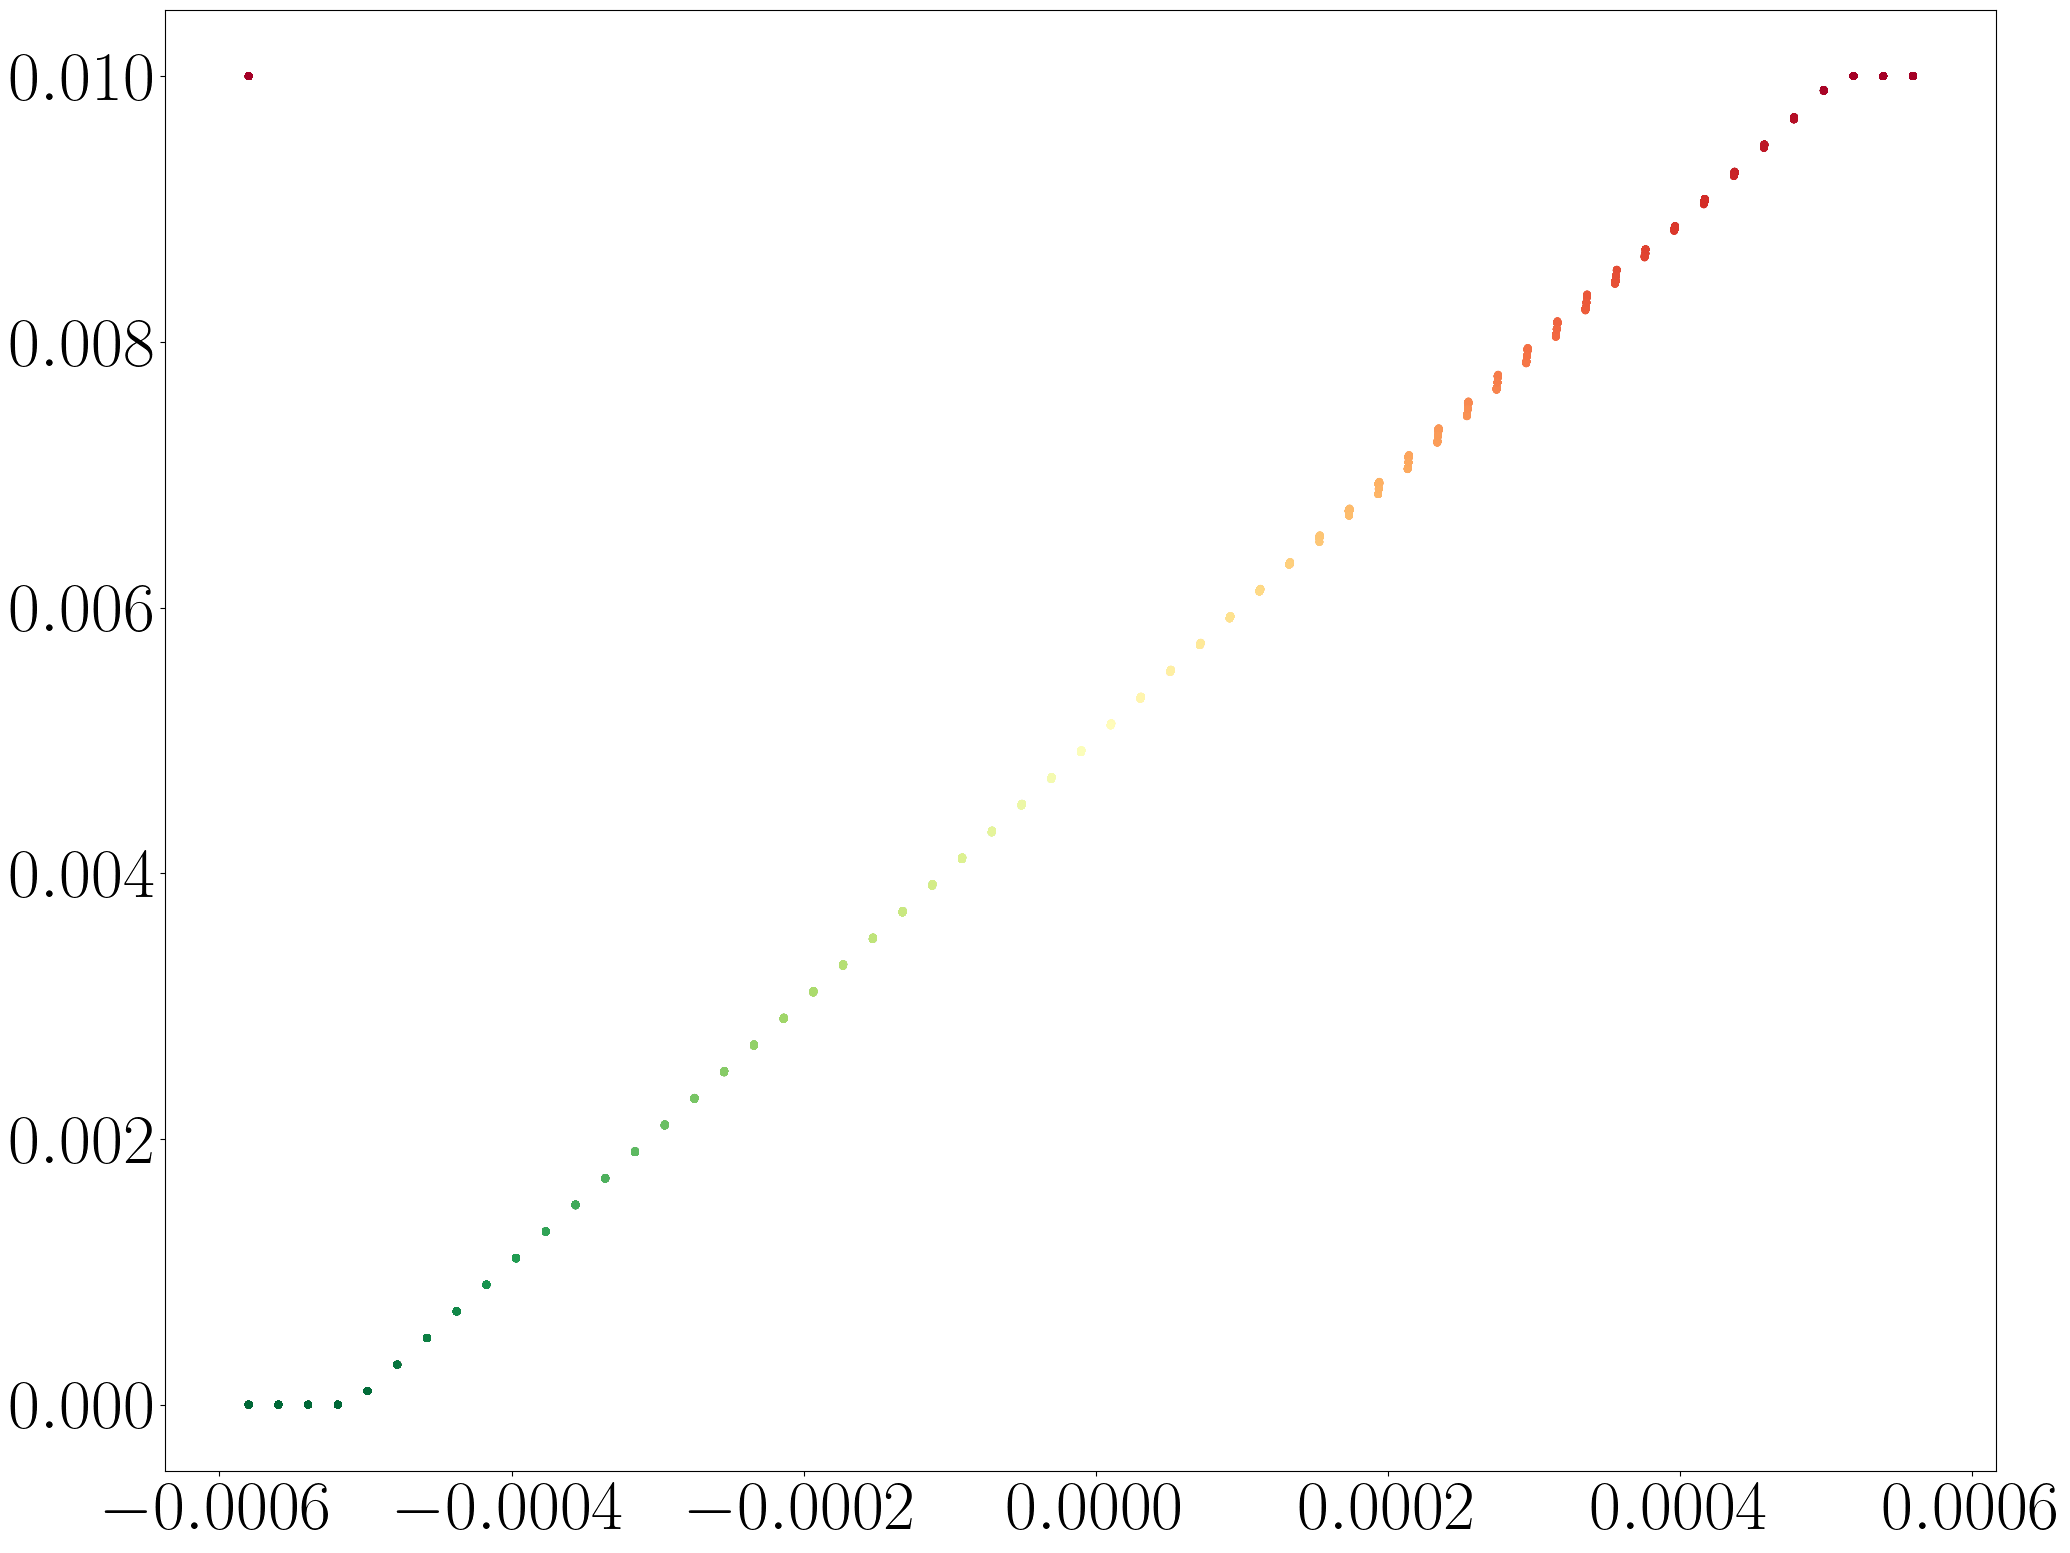

read_vtk.py: Read vtk-file: /scratch/local1/krach/SPH/development/main_branch/hoomd-sph3/sph-simulations/99_singlephaseflow_benchmarks/03_couette_flow/couette_flow_100_108_17_vs_1e-05_run/couette_flow_100_108_17_vs_1e-05_run_20000.vtu
read_vtk.py: Read Positions: Number of loaded points 183600
read_vtk.py: Load field Pressure
read_vtk.py: Load field Velocity x
read_vtk.py: Load field Velocity y


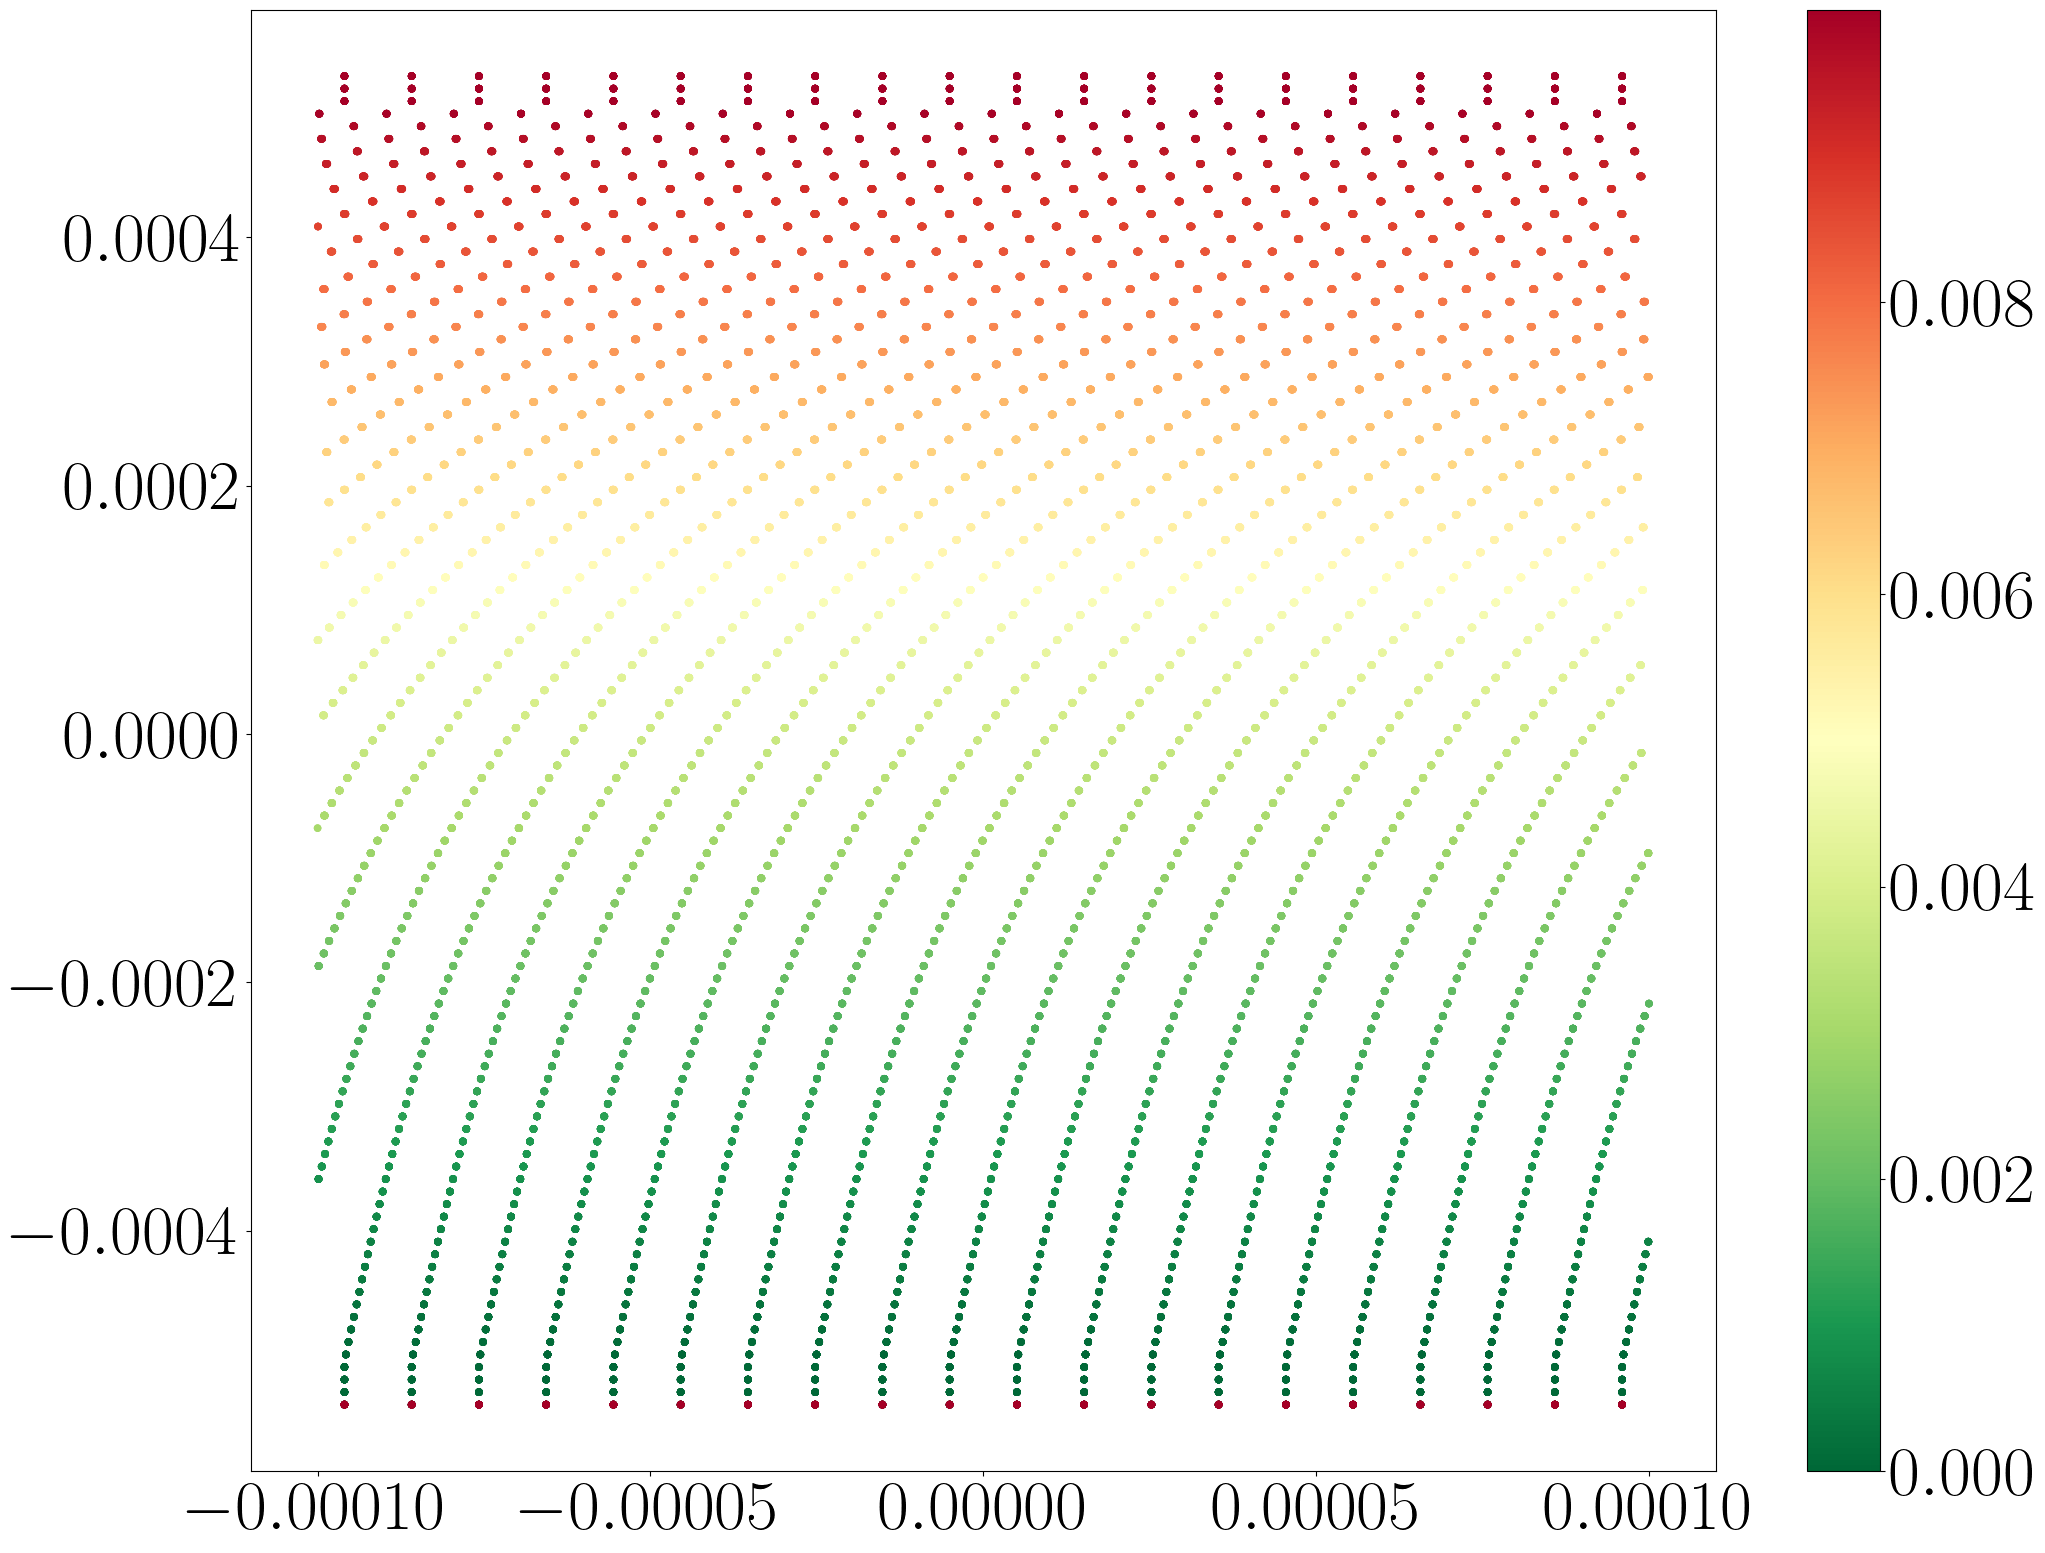

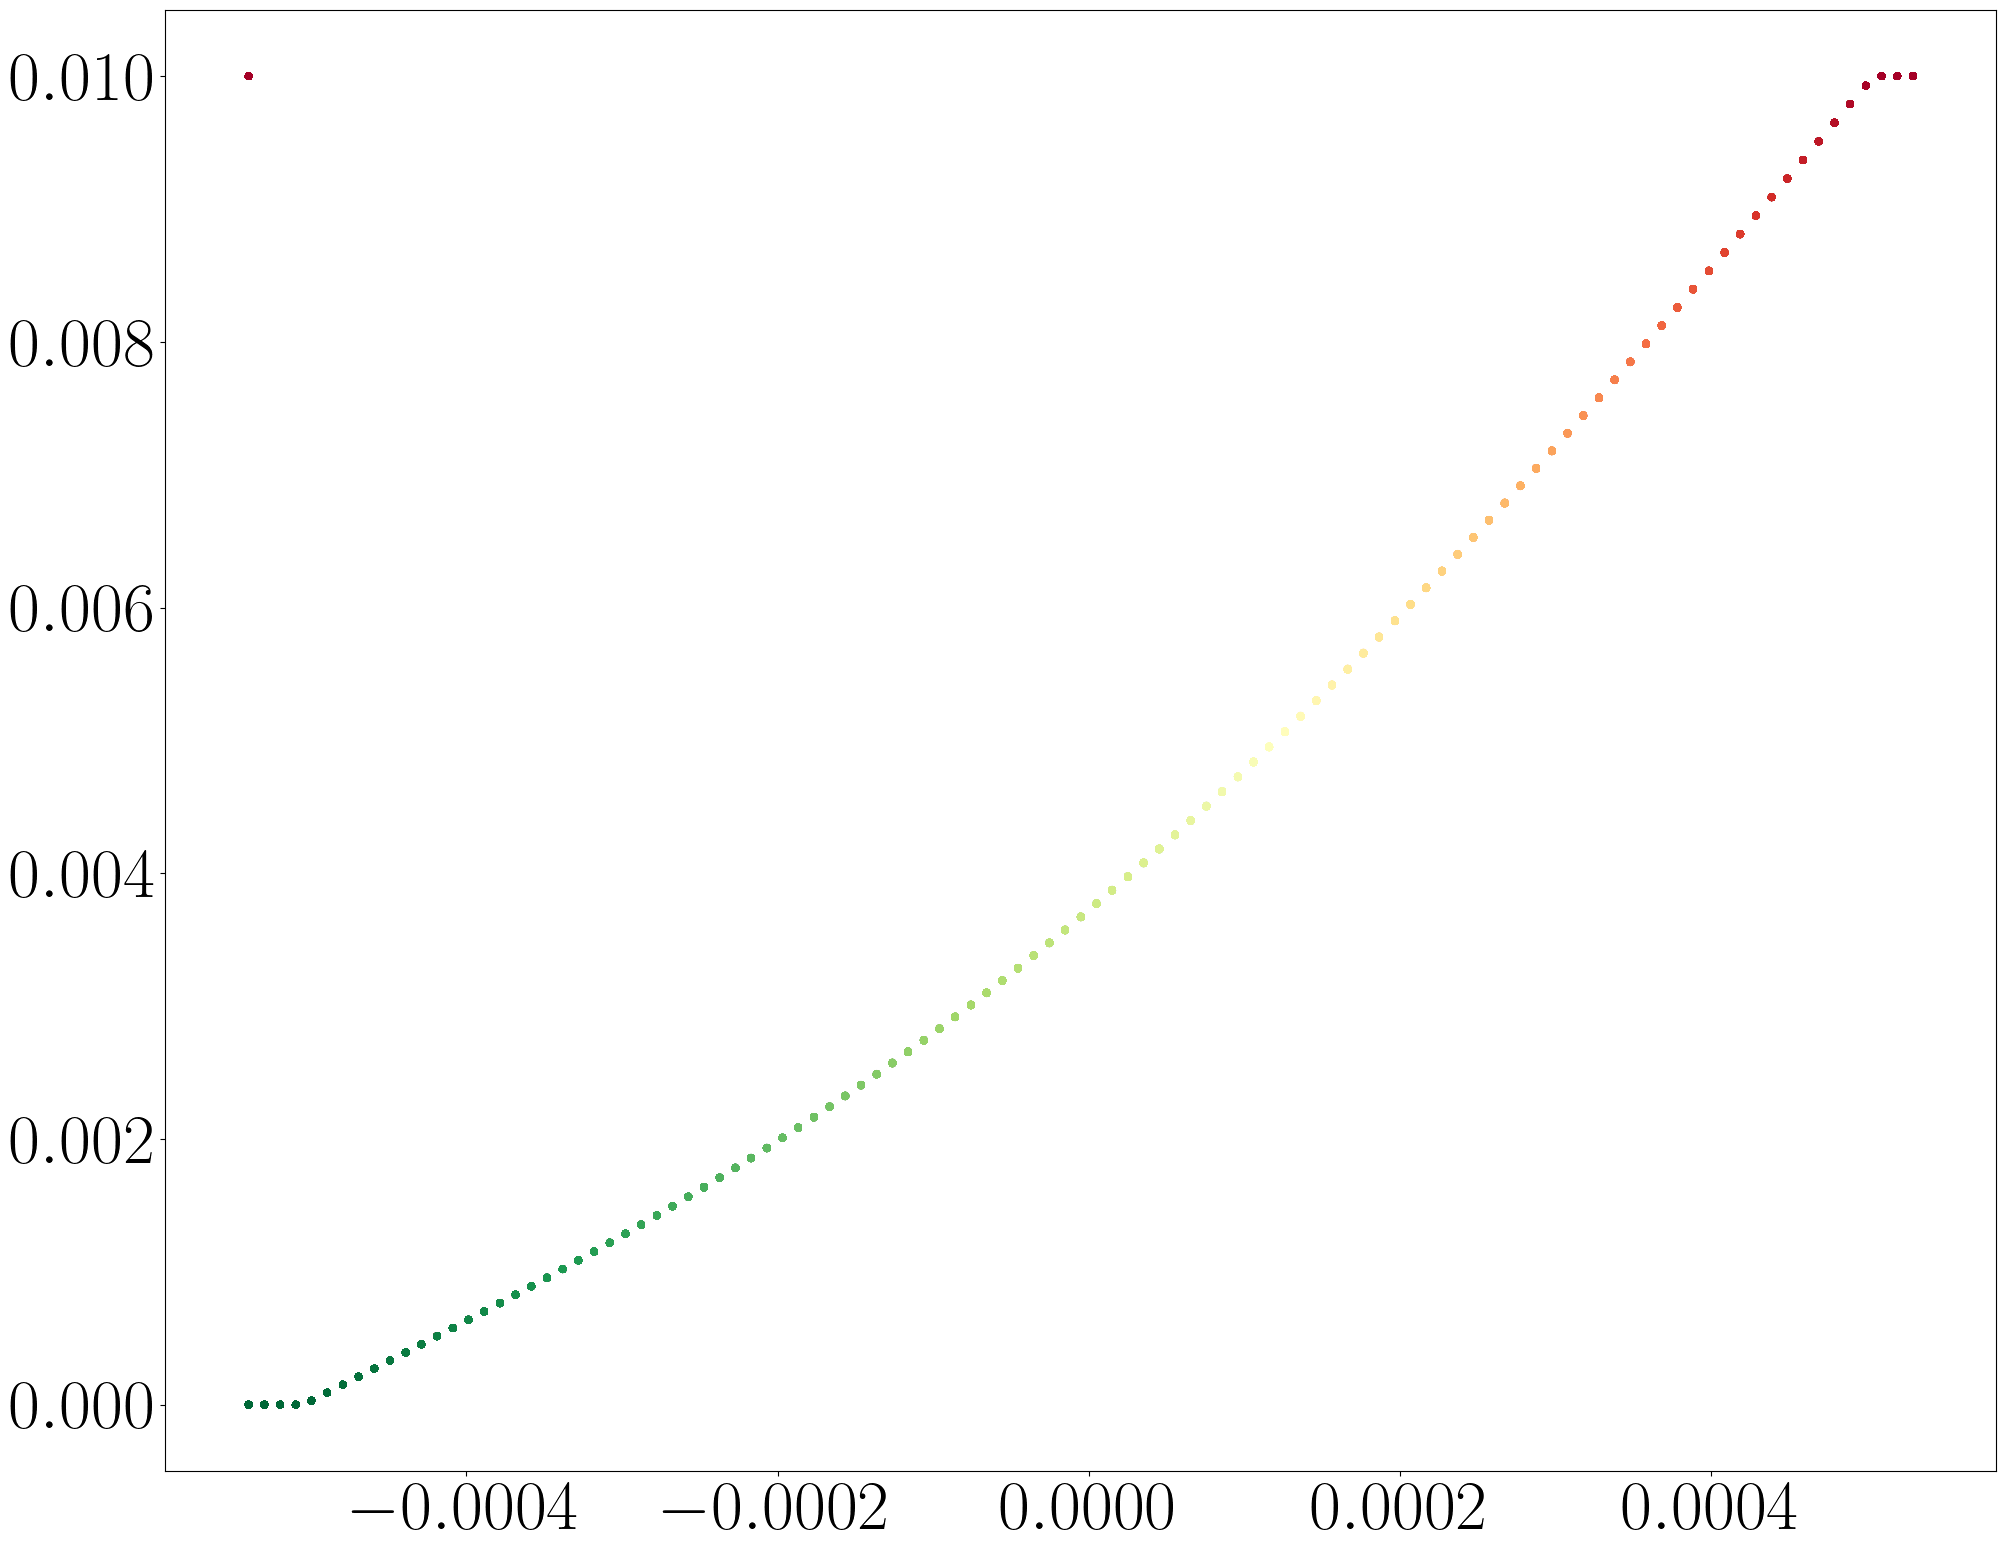

In [103]:
# Comparison with a analytical solution
vtufiles =  [
    'couette_flow_20_28_17_vs_5e-05_run/couette_flow_20_28_17_vs_5e-05_run_20000.vtu',
    'couette_flow_30_38_17_vs_3.3333333333333335e-05_run/couette_flow_30_38_17_vs_3.3333333333333335e-05_run_20000.vtu',
    'couette_flow_50_58_17_vs_2e-05_run/couette_flow_50_58_17_vs_2e-05_run_20000.vtu',
    'couette_flow_100_108_17_vs_1e-05_run/couette_flow_100_108_17_vs_1e-05_run_20000.vtu'
]

for i in range(len(vtufiles)):

    data = vtk_tools.openvtu(f'{global_path}{path_couette}/{vtufiles[i]}', ['Pressure', 'Velocity x', 'Velocity y'])

    tdata_points_y = []
    tdata_points_z = []
    tdata_vels = []
    for i in range(data['Points'].shape[0]):
        if data['Points'][i, 0] < 0.0001  and data['Points'][i, 0] > -0.0001:
            tdata_points_y.append(data['Points'][i, 0])
            tdata_points_z.append(data['Points'][i, 1])
            tdata_vels.append(data['Velocity x'][i])

    im = plt.scatter(tdata_points_y, tdata_points_z, c = tdata_vels, s = 20, cmap = cm)
    plt.colorbar(im)
    plt.show()
    plt.close()
    
    plt.scatter(tdata_points_z, tdata_vels, c = tdata_vels, s = 20, cmap = cm)
    plt.show()
    plt.close()

## Channel Flow
Convergence, discretisation, and analytical solution

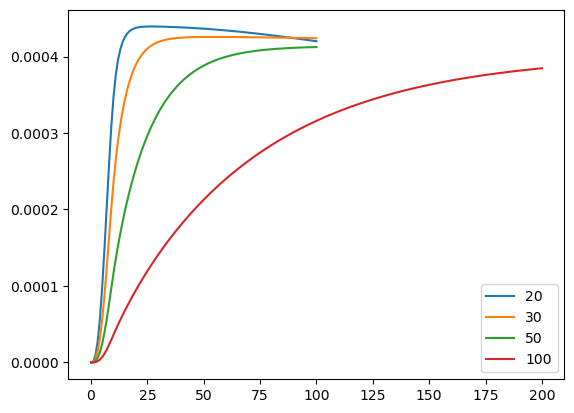

In [18]:
simulations_res = [
                    20, 
                    30, 
                    50, 
                    100
]

path_channel = '04_channel_flow'
logfiles_channel = [
    'channel_flow_20_32_32_vs_5e-05_run.log',
    'channel_flow_30_42_42_vs_3.3333333333333335e-05_run.log',
    'channel_flow_50_62_62_vs_2e-05_run.log',
    'channel_flow_100_112_112_vs_1e-05_run.log'
]

for i in range(len(simulations_res)):
    conv_data = np.genfromtxt(f'{global_path}{path_channel}/{logfiles_channel[i]}', skip_header = 1)[:, -2]
    number_fparticles = np.genfromtxt(f'{global_path}{path_channel}/{logfiles_channel[i]}', skip_header = 1)[-1, -3]
    norm_conv_data = np.divide(conv_data, number_fparticles)
    plt.plot(norm_conv_data, label = f'{simulations_res[i]}')
    plt.legend()
plt.show()

## Liddriven Cavity

In [125]:
# Convergence
path_ldc = '05_liddriven_cavity'
logfiles_ldc = [
    '',
    '',
    '',
    ''
]